En este fichero voy a probar con transformadas wavelet

Este es el mejor resultado que he obtenido hasta ahora y parece consistente

Los resultados están funcionando con APPLE

In [ ]:
# Esto es sólo para ver si la TPU está disponible
import os
print("TPU disponible:", "COLAB_TPU_ADDR" in os.environ)

TPU disponible: False


In [ ]:
# Si no setecta TPU, entonces intentamos forzar la conexión

import tensorflow as tf

# Intenta conectarte a la TPU manualmente
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # Detectar TPU
    print('Dispositivo TPU detectado:', tpu.cluster_spec().as_dict())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
    print(f"Número de aceleradores: {strategy.num_replicas_in_sync}")
except ValueError:
    print("No se detectó TPU. Usando estrategia por defecto.")
    strategy = tf.distribute.get_strategy()

No se detectó TPU. Usando estrategia por defecto.


In [6]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Wed Jul  9 15:18:57 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 552.44                 Driver Version: 552.44         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce GTX 850A      WDDM  |   00000000:08:00.0 Off |                  N/A |
| N/A    0C    P8             N/A /   32W |       0MiB /   2048MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [5]:
import tensorflow as tf
print("Versión TensorFlow:", tf.__version__)
print("GPUs detectadas:", tf.config.list_physical_devices('GPU'))

# Para ver detalles sobre cada GPU:
gpus = tf.config.list_physical_devices('GPU')
for gpu in gpus:
    print(gpu)

Versión TensorFlow: 2.10.0
GPUs detectadas: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [3]:
import tensorflow as tf

print("Versión TensorFlow:", tf.__version__)

gpus = tf.config.list_physical_devices('GPU')
print("GPUs disponibles:", gpus)

if gpus:
    for gpu in gpus:
        details = tf.config.experimental.get_device_details(gpu)
        print(f"GPU detectada: {gpu}, detalles: {details}")
else:
    print("No se detectó ninguna GPU.")

Versión TensorFlow: 2.18.0
GPUs disponibles: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
GPU detectada: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), detalles: {'compute_capability': (7, 5), 'device_name': 'Tesla T4'}


In [3]:
import tensorflow as tf
print(tf.__version__)
print("GPU disponible:", tf.config.list_physical_devices('GPU'))

2.10.0
GPU disponible: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


Indicar aquí si estamos en Colab

In [8]:
colab = False
from IPython.display import Audio

Carga de datos

In [ ]:
#!pip install pandas

In [9]:
import numpy as np
import pandas as pd
import os

def load_data(names):

    Data = []

    for i in range(len(names)):

        if colab:
            Data.append(pd.read_csv('/content/' + names[i] + '_60min_data.csv', sep=",", decimal="."))
        else:
        # Cambio al directorio donde tengo los datos
            os.chdir('C:/Users/oscar/SynologyDrive/Master IA/TFM/Pruebas previas/Datos')
            Data.append(pd.read_csv(names[i] + '_60min_data.csv', sep=",", decimal="."))

        Data[i]['timestamp'] = pd.to_datetime(Data[i]['timestamp'])

        Data[i] = Data[i].sort_values('timestamp', ascending=True).reset_index(drop=True)

    return Data

Data = load_data(['AAPL', 'META', 'MSFT', 'GOOGL', 'AMZN', 'IBM', 'NVDA', 'INTC', 'QCOM','AMD', 'NFLX'])
#Data = load_data(['AAPL'])

for data in Data:
    print(len(data))
    print(data.head())
    print()

11697
            timestamp      open      high       low     close  volume
0 2021-11-01 04:00:00  147.4856  147.6823  147.1020  147.1413   44613
1 2021-11-01 05:00:00  147.1413  147.2790  147.1020  147.1413   26860
2 2021-11-01 06:00:00  147.1413  147.2200  147.0528  147.2200   35363
3 2021-11-01 07:00:00  147.2299  147.3872  147.0430  147.2004  180892
4 2021-11-01 08:00:00  147.2594  147.3872  146.9545  146.9938  322671

11833
            timestamp      open      high       low     close  volume
0 2021-11-01 04:00:00  323.0307  327.5970  323.0307  327.5471   12466
1 2021-11-01 05:00:00  327.4474  327.4474  326.3009  326.5202   14019
2 2021-11-01 06:00:00  326.5003  326.5003  326.0217  326.3507    8748
3 2021-11-01 07:00:00  326.3408  326.3707  325.3238  325.9320   23446
4 2021-11-01 08:00:00  325.5232  326.2809  324.5860  325.2740   68030

11885
            timestamp      open      high       low     close  volume
0 2021-11-01 04:00:00  323.2577  324.6713  323.2577  324.5835    6994


In [10]:
# Eliminación de horas fuera de mercado

for i in range(len(Data)):
    # Filtrar por horario de mercado (09:30 a 16:00)
    Data[i] = Data[i][(Data[i]['timestamp'].dt.time >= pd.to_datetime('09:30').time()) &
                      (Data[i]['timestamp'].dt.time <= pd.to_datetime('16:00').time())]

    # Reinicia el índice después del filtro
    Data[i].reset_index(drop=True, inplace=True)

for data in Data:
    print(data.head())

            timestamp      open      high       low     close   volume
0 2021-11-01 10:00:00  145.8037  146.4200  145.3709  145.9217  9677581
1 2021-11-01 11:00:00  145.9119  146.5905  145.8135  146.4430  5079173
2 2021-11-01 12:00:00  146.4528  146.5758  146.2168  146.4873  5453416
3 2021-11-01 13:00:00  146.4922  146.5709  146.0693  146.1283  4248144
4 2021-11-01 14:00:00  146.1184  146.2561  145.8332  145.9070  4253565
            timestamp      open      high       low     close   volume
0 2021-11-01 10:00:00  331.0068  331.6947  328.7735  329.2819  3332240
1 2021-11-01 11:00:00  329.2520  331.5551  329.0128  330.9669  2224676
2 2021-11-01 12:00:00  330.9569  331.9340  329.5910  329.9051  1607476
3 2021-11-01 13:00:00  329.9001  330.3288  326.7097  328.1354  2294689
4 2021-11-01 14:00:00  328.1055  328.4445  326.2909  328.1753  2170685
            timestamp      open      high       low     close   volume
0 2021-11-01 10:00:00  319.3779  319.7288  318.1593  318.3104  3380259
1 2021

In [11]:
import pandas as pd
import numpy as np

def replace_outliers_dynamic(df, column, window_size=10, threshold=3):
    """
    Reemplaza valores atípicos en una serie, calculando la media y desviación estándar dinámicamente
    en una ventana de tamaño fijo.

    Args:
        df (pd.DataFrame): El dataframe.
        column (str): Nombre de la columna a procesar.
        window_size (int): Número de datos anteriores para calcular media y desviación estándar.
        threshold (float): Número de desviaciones estándar para considerar un valor como atípico.

    Returns:
        pd.DataFrame: DataFrame con valores atípicos reemplazados.
    """
    data = df[column].copy()

    # Iterar desde el índice `window_size` hasta el penúltimo elemento
    for i in range(window_size, len(data) - 1):
        # Calcular media y desviación estándar de los 10 valores anteriores
        window = data.iloc[i - window_size:i]
        mean = window.mean()
        std = window.std()

        # Verificar si el dato actual es un valor atípico
        if np.abs(data.iloc[i] - mean) > threshold * std:
            # Reemplazar por la media de los valores anterior y posterior

            data.iloc[i] = (data.iloc[i - 1] + data.iloc[i + 1]) / 2


    df[column] = data
    return df

def hampel_filter_bidirectional(df, column, window_size=10, threshold=3):
    """
    Versión bidireccional del filtro de Hampel que considera ventanas centradas.

    Args:
        df (pd.DataFrame): El dataframe.
        column (str): Nombre de la columna a procesar.
        window_size (int): Tamaño total de la ventana (debe ser impar).
        threshold (float): Número de MADs para considerar un valor como atípico.

    Returns:
        pd.DataFrame: DataFrame con valores atípicos reemplazados.
    """
    data = df[column].copy()
    half_window = window_size // 2

    # Iterar desde half_window hasta len(data) - half_window
    for i in range(half_window, len(data) - half_window):
        # Obtener ventana centrada en el punto actual
        window = data.iloc[i - half_window:i + half_window + 1]

        # Calcular mediana de la ventana
        median = window.median()

        # Calcular MAD
        mad = np.median(np.abs(window - median))
        mad_scaled = mad * 1.4826

        # Verificar si el dato actual es un valor atípico
        if mad_scaled > 0:
            if np.abs(data.iloc[i] - median) > threshold * mad_scaled:
                # Reemplazar por la mediana de la ventana
                data.iloc[i] = median

    df[column] = data
    return df


for e in range(len(Data)):

    # Aplicar la función a una columna específica
#    Data[e] = replace_outliers_dynamic(data, column='open', window_size=10, threshold=5)
#    Data[e] = replace_outliers_dynamic(data, column='close', window_size=10, threshold=5)
#    Data[e] = replace_outliers_dynamic(data, column='high', window_size=10, threshold=5)
#    Data[e] = replace_outliers_dynamic(data, column='low', window_size=10, threshold=5)

    Data[e] = hampel_filter_bidirectional(Data[e], column='open', window_size=11, threshold=3)
    Data[e] = hampel_filter_bidirectional(Data[e], column='close', window_size=11, threshold=3)
    Data[e] = hampel_filter_bidirectional(Data[e], column='high', window_size=11, threshold=3)
    Data[e] = hampel_filter_bidirectional(Data[e], column='low', window_size=11, threshold=3)



    # Visualizar el resultado
    print(Data[e])


print('Script finalizado')
Audio('r2d2-squeaks1.mp3', autoplay=True)

               timestamp      open      high       low     close    volume
0    2021-11-01 10:00:00  145.8037  146.4200  145.3709  145.9217   9677581
1    2021-11-01 11:00:00  145.9119  146.5905  145.8135  146.4430   5079173
2    2021-11-01 12:00:00  146.4528  146.5758  146.2168  146.4873   5453416
3    2021-11-01 13:00:00  146.4922  146.5709  146.0693  146.1283   4248144
4    2021-11-01 14:00:00  146.1184  146.2561  145.8332  145.9070   4253565
...                  ...       ...       ...       ...       ...       ...
5119 2024-09-30 12:00:00  232.2500  232.5383  231.7400  231.7878   3087886
5120 2024-09-30 13:00:00  231.7800  232.0399  231.3100  231.8400   2550516
5121 2024-09-30 14:00:00  231.8250  231.9100  230.5500  231.7516   3421941
5122 2024-09-30 15:00:00  231.7350  233.0000  231.0400  233.0000  10554085
5123 2024-09-30 16:00:00  233.0000  233.2500  220.3100  232.8600  26489257

[5124 rows x 6 columns]
               timestamp      open      high       low     close   volume
0

In [ ]:
#!pip install matplotlib

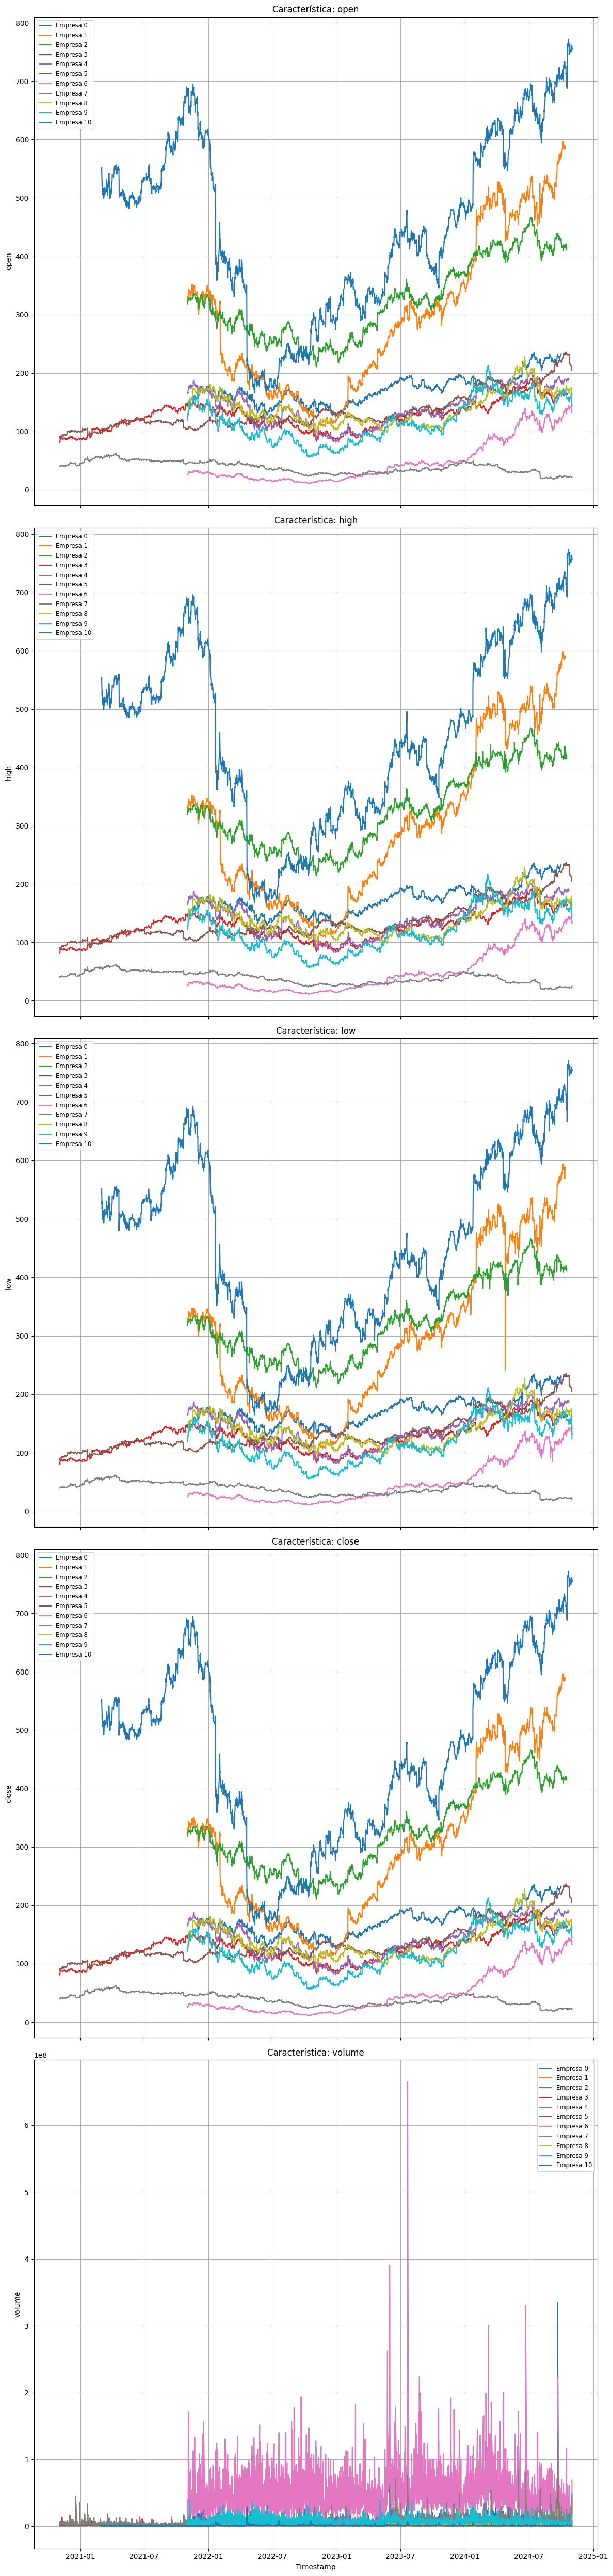

In [ ]:
# Representación de los datos

import matplotlib.pyplot as plt

def plot_features_by_company(dataframes_list):
    """
    Grafica las características comunes ('open', 'high', 'low', 'close', 'volume') para todas las empresas.
    Cada gráfico representa una característica y en él aparecen todas las empresas.

    Args:
        dataframes_list (list): Lista de DataFrames de pandas, uno por empresa.
    """
    # Lista de características a graficar
    features = ['open', 'high', 'low', 'close', 'volume']

    # Crear un subplot por característica
    num_features = len(features)
    fig, axs = plt.subplots(num_features, 1, figsize=(12, 10 * num_features), sharex=True)

    for i, feature in enumerate(features):
        ax = axs[i]
        for j, df in enumerate(dataframes_list):
            if feature in df.columns:  # Verificar que la característica exista en el DataFrame
                ax.plot(df['timestamp'], df[feature], label=f'Empresa {j}')

        ax.set_title(f'Característica: {feature}')
        ax.set_ylabel(feature)
        ax.legend(loc='best', fontsize='small')
        ax.grid()

    # Configurar eje X en el último subplot
    axs[-1].set_xlabel('Timestamp')

    plt.tight_layout()
    plt.show()

# Ejemplo de uso
plot_features_by_company(Data)


Cálculo de los indicadores técnicos

In [12]:
import pandas as pd
import numpy as np

print('Comienzo de los cálculos')

# Cargar datos de mercado (precios, volumen, etc.)
# Asegúrate de que tu archivo CSV tenga columnas como 'close', 'high', 'low', 'volume', etc.


# Eliminar cualquier valor nulo para evitar errores en los cálculos
#Data = Data.dropna()

# 1. Media Móvil Simple (SMA)
def SMA(Data, window):
    return Data.rolling(window=window).mean()



# 2. Media Móvil Exponencial (EMA)
def EMA(Data, window):
    return Data.ewm(span=window, adjust=False).mean()



# 3. Índice de Fuerza Relativa (RSI)
def RSI(Data, window=14*16):
    delta = Data.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))



# 4. MACD (Moving Average Convergence Divergence)
def MACD(Data, slow=26*16, fast=12*16, signal=9*16):
    ema_fast = EMA(Data, fast)
    ema_slow = EMA(Data, slow)
    macd_line = ema_fast - ema_slow
    signal_line = EMA(macd_line, signal)
    macd_diff = macd_line - signal_line
    return macd_line, signal_line, macd_diff



# 5. Bandas de Bollinger
def bollinger_bands(Data, window=20):
    sma = SMA(Data, window)
    std = Data.rolling(window).std()
    upper_band = sma + (std * 2)
    lower_band = sma - (std * 2)
    return upper_band, lower_band



# 6. ADX (Average Directional Index)
def ADX(high, low, close, window=14):
    tr = np.maximum(high - low, np.maximum(abs(high - close.shift(1)), abs(low - close.shift(1))))
    atr = tr.rolling(window).mean()

    up_move = high.diff()
    down_move = low.diff()

    plus_dm = np.where((up_move > down_move) & (up_move > 0), up_move, 0)
    minus_dm = np.where((down_move > up_move) & (down_move > 0), down_move, 0)

    # Convertimos plus_dm y minus_dm a series de pandas para usar rolling()
    plus_di = 100 * (pd.Series(plus_dm).rolling(window).mean() / atr)
    minus_di = 100 * (pd.Series(minus_dm).rolling(window).mean() / atr)
    dx = 100 * np.abs(plus_di - minus_di) / (plus_di + minus_di)

    adx = dx.rolling(window).mean()
    return adx, plus_di, minus_di



# 7. Oscilador Estocástico
def stochastic_oscillator(high, low, close, k_window=14, d_window=3):
    lowest_low = low.rolling(window=k_window).min()
    highest_high = high.rolling(window=k_window).max()
    k_line = 100 * ((close - lowest_low) / (highest_high - lowest_low))
    d_line = k_line.rolling(window=d_window).mean()
    return k_line, d_line



# 8. ATR (Average True Range)
def ATR(high, low, close, window=14):
    tr = np.maximum(high - low, np.maximum(abs(high - close.shift(1)), abs(low - close.shift(1))))
    return tr.rolling(window).mean()



# 9. Tasa de Cambio (ROC)
def ROC(Data, window=12):
    return ((Data - Data.shift(window)) / Data.shift(window)) * 100



# 10. Oscilador de Chaikin
def Chaikin_Money_Flow(high, low, close, volume, window=20):
    mf_multiplier = ((close - low) - (high - close)) / (high - low)
    mf_volume = mf_multiplier * volume
    return mf_volume.rolling(window=window).sum() / volume.rolling(window=window).sum()



# 11. Nube de Ichimoku
def Ichimoku(high, low, close, i):
    nine_period_high = high.rolling(window=9).max()
    nine_period_low = low.rolling(window=9).min()
    Data[i]['Ichimoku_conversion_line'] = (nine_period_high + nine_period_low) / 2

    period26_high = high.rolling(window=26).max()
    period26_low = low.rolling(window=26).min()
    Data[i]['Ichimoku_base_line'] = (period26_high + period26_low) / 2

    Data[i]['Ichimoku_a'] = ((Data[i]['Ichimoku_conversion_line'].shift(26) + Data[i]['Ichimoku_base_line'].shift(26)) / 2)
    Data[i]['Ichimoku_b'] = ((high.rolling(window=52).max() + low.rolling(window=52).min()) / 2)



# 12. Volumen Relativo
#Data['Volume_Relative'] = Data['volume'] / Data['volume'].rolling(window=20).mean()

for i in range(len(Data)):

    Data[i]['SMA_20'] = SMA(Data[i]['close'], 16)
    Data[i]['SMA_50'] = SMA(Data[i]['close'], 16*5)
    Data[i]['SMA_200'] = SMA(Data[i]['close'], 16*22)

    Data[i]['EMA_20'] = EMA(Data[i]['close'], 16)
    Data[i]['EMA_50'] = EMA(Data[i]['close'], 16*5)

    Data[i]['RSI_14'] = RSI(Data[i]['close'], 14)

    Data[i]['MACD'], Data[i]['MACD_signal'], Data[i]['MACD_diff'] = MACD(Data[i]['close'])

    Data[i]['Bollinger_High'], Data[i]['Bollinger_Low'] = bollinger_bands(Data[i]['close'])

    Data[i]['ADX'], Data[i]['DI+'], Data[i]['DI-'] = ADX(Data[i]['high'], Data[i]['low'], Data[i]['close'])

    Data[i]['Stoch_%K'], Data[i]['Stoch_%D'] = stochastic_oscillator(Data[i]['high'], Data[i]['low'], Data[i]['close'])

    Data[i]['ATR'] = ATR(Data[i]['high'], Data[i]['low'], Data[i]['close'])

    Data[i]['ROC'] = ROC(Data[i]['close'])

    Data[i]['Chaikin_Oscillator'] = Chaikin_Money_Flow(Data[i]['high'], Data[i]['low'], Data[i]['close'], Data[i]['volume'])

    Ichimoku(Data[i]['high'], Data[i]['low'], Data[i]['close'], i)

    Data[i]['Volume_Relative'] = Data[i]['volume'] / Data[i]['volume'].rolling(window=20).mean()

    Data[i] = Data[i].dropna().reset_index(drop=True)





# Guarda los resultados con todos los indicadores
#Data = Data.dropna().reset_index(drop=True)
#Data.to_csv('market_Data_with_indicators.csv', index=False)

# Visualizar las primeras filas de los datos con los indicadores
for data in Data:
    print(len(data))
    print(data.head())
    print()

Comienzo de los cálculos
4773
            timestamp      open      high       low     close   volume  \
0 2022-01-12 11:00:00  173.0046  173.6104  172.1969  173.1917  9384075   
1 2022-01-12 12:00:00  173.2016  173.7433  172.6796  172.8666  6189890   
2 2022-01-12 13:00:00  173.5956  173.6301  172.8371  172.9356  4861133   
3 2022-01-12 14:00:00  172.9307  173.1720  172.5909  172.8666  5087254   
4 2022-01-12 15:00:00  172.8667  173.3001  172.4530  172.9750  9089798   

       SMA_20      SMA_50     SMA_200      EMA_20  ...   Stoch_%K   Stoch_%D  \
0  170.254650  174.154896  163.152362  171.336696  ...  84.813740  88.954256   
1  170.673687  174.096295  163.228910  171.516685  ...  78.037743  81.871019   
2  171.073531  174.042981  163.304173  171.683616  ...  77.668727  80.173404   
3  171.433050  173.981171  163.379114  171.822790  ...  76.697129  77.467866   
4  171.707000  173.933399  163.455383  171.958345  ...  74.717172  76.361009   

        ATR       ROC  Chaikin_Oscillator  I

In [10]:
print(len(Data[6]))


4934


Se pintan los indicadores técnicos

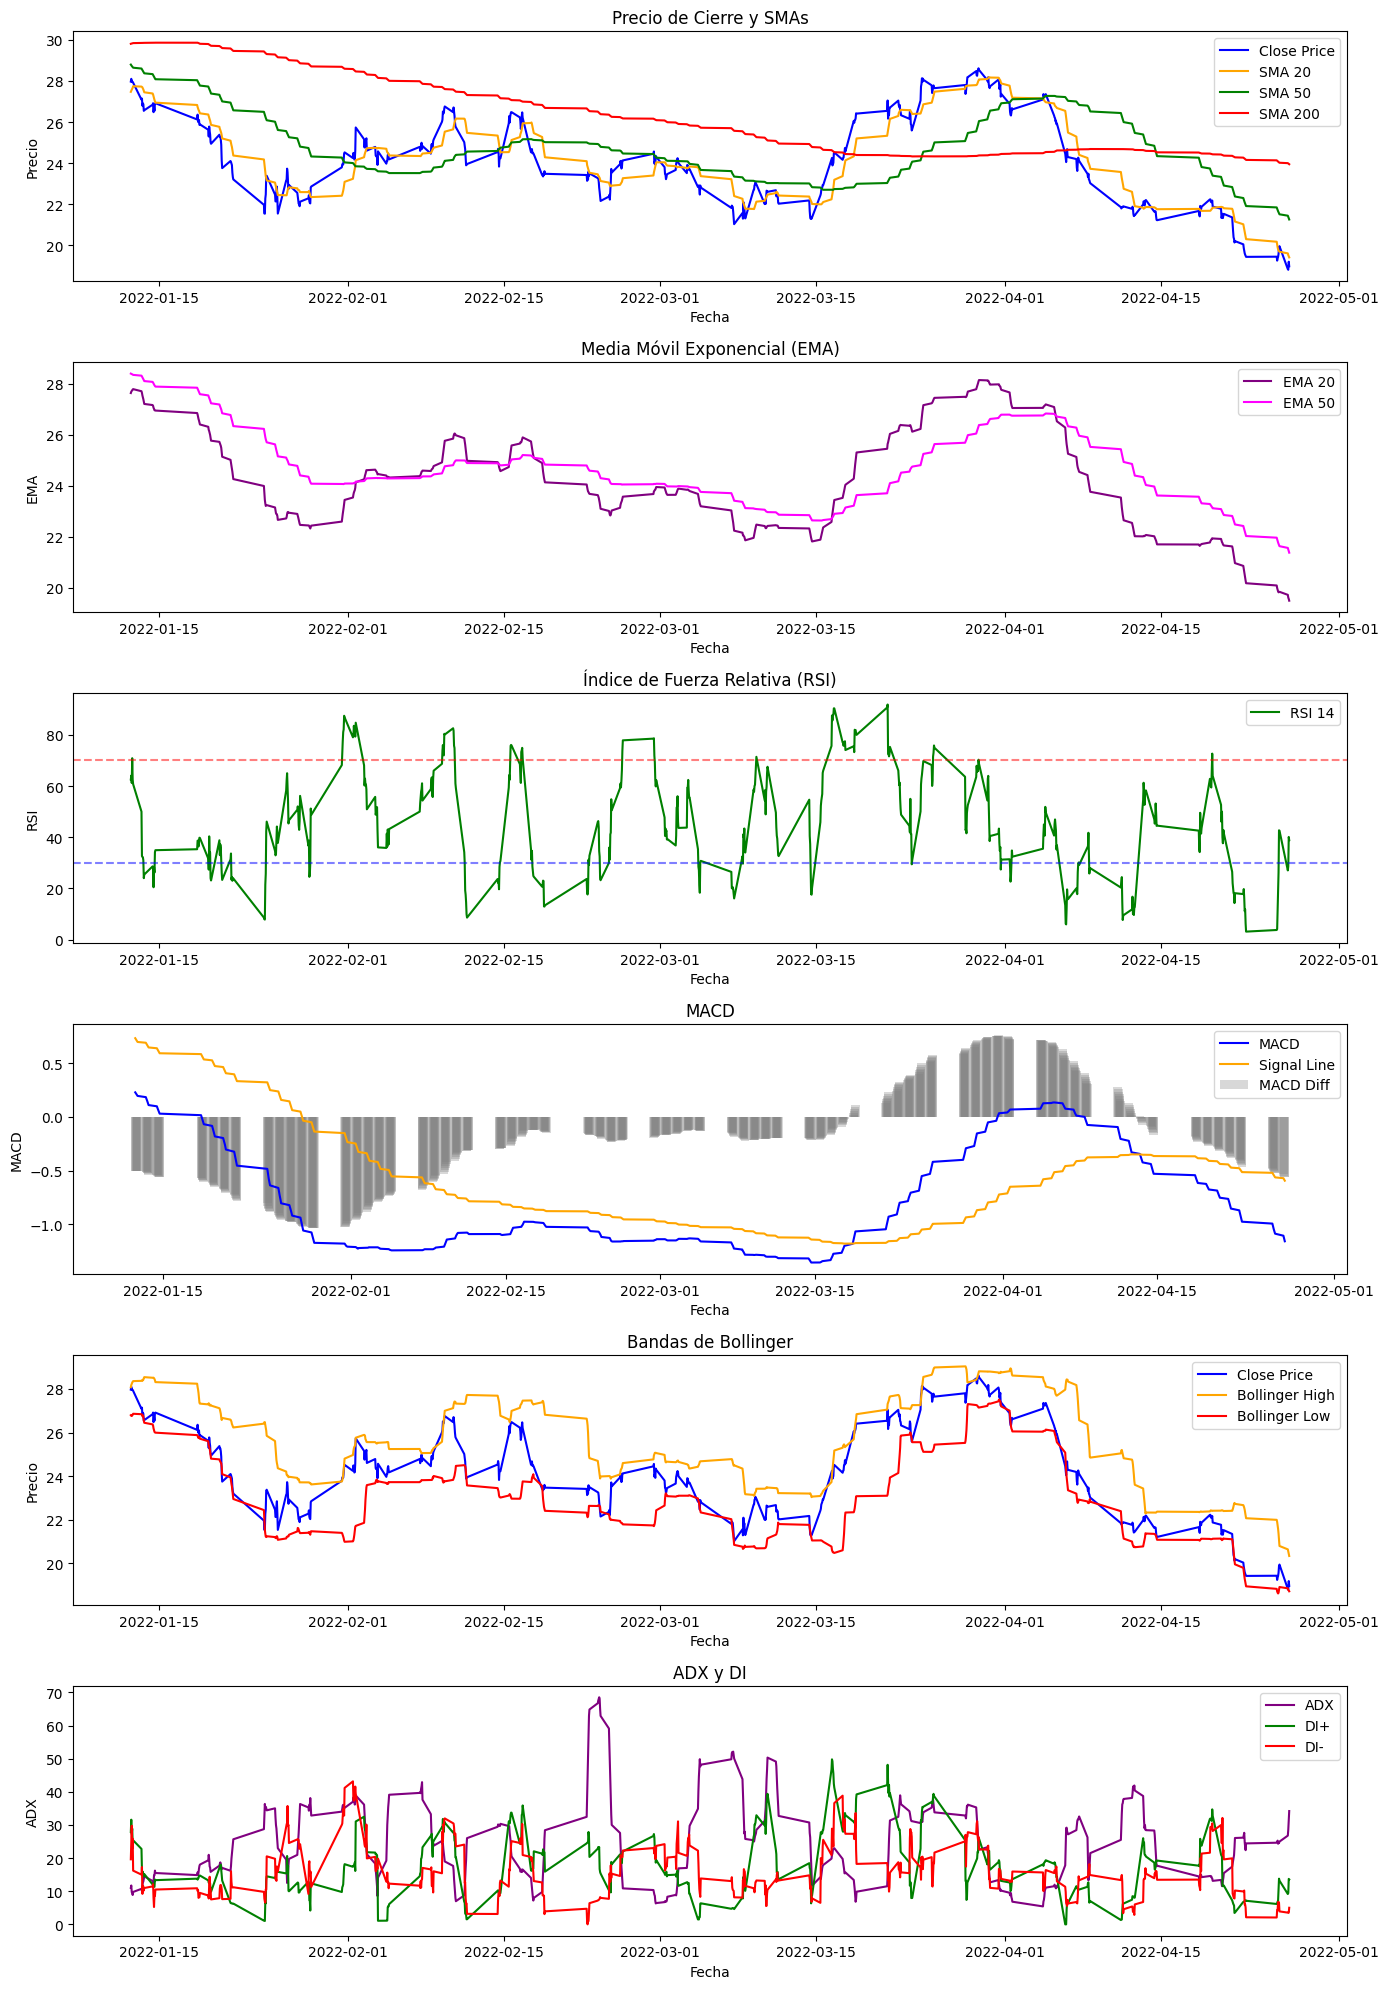

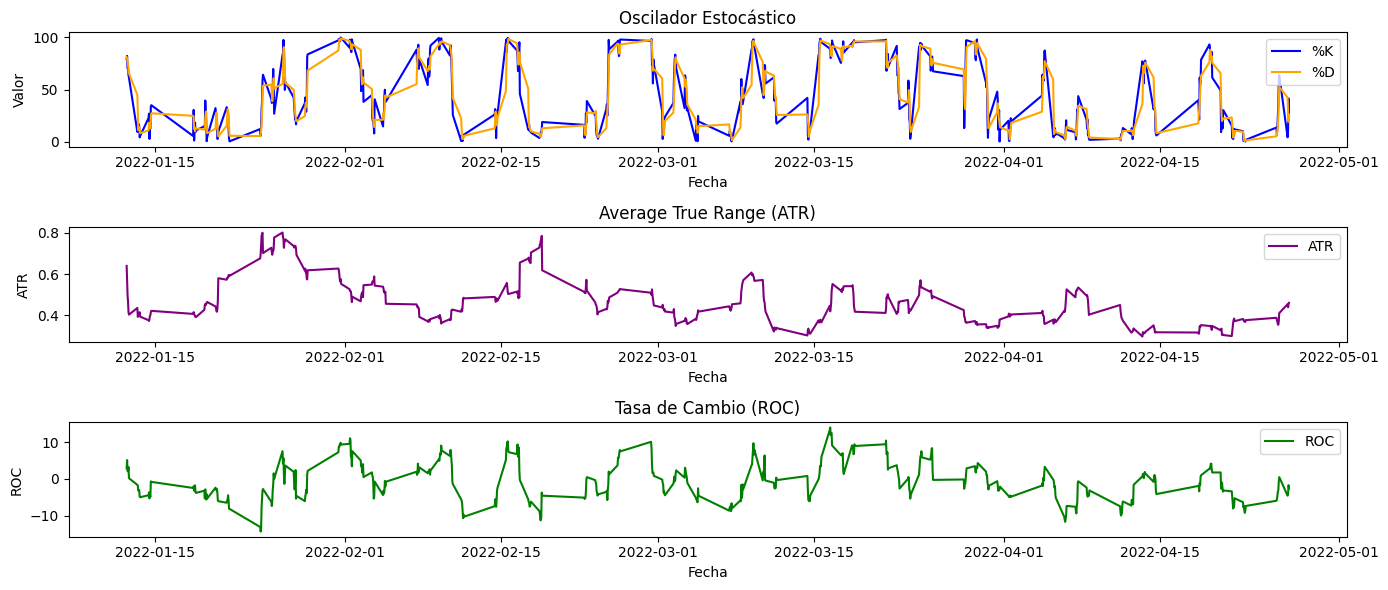

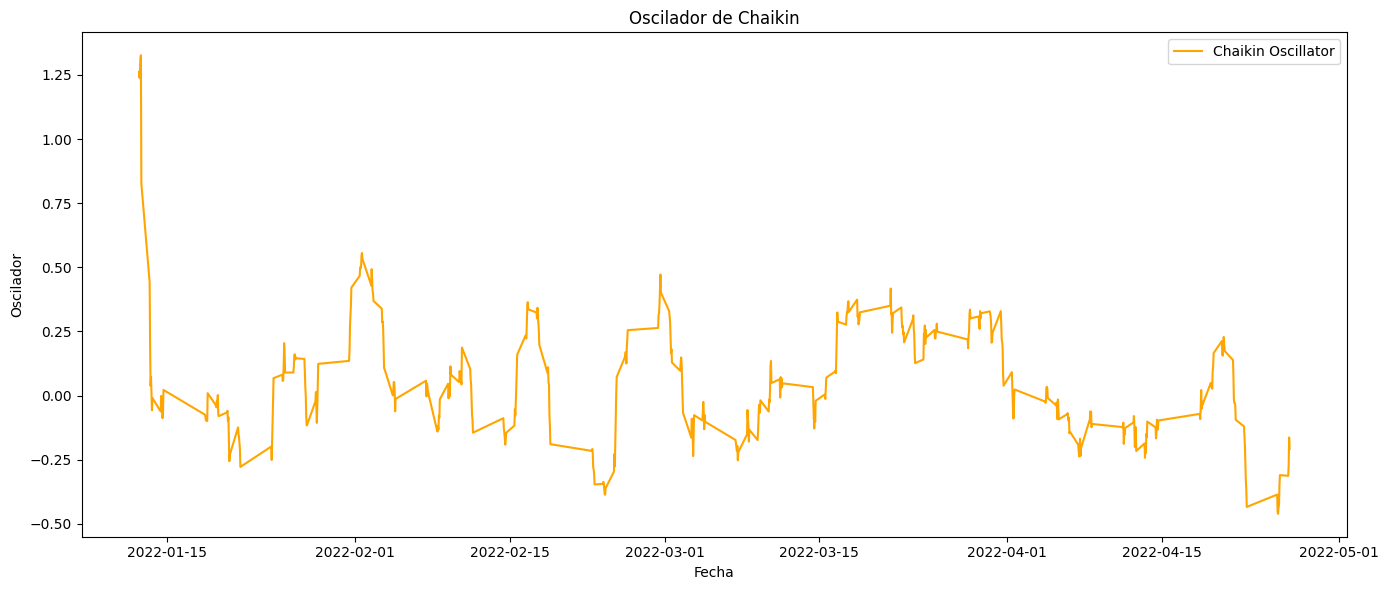

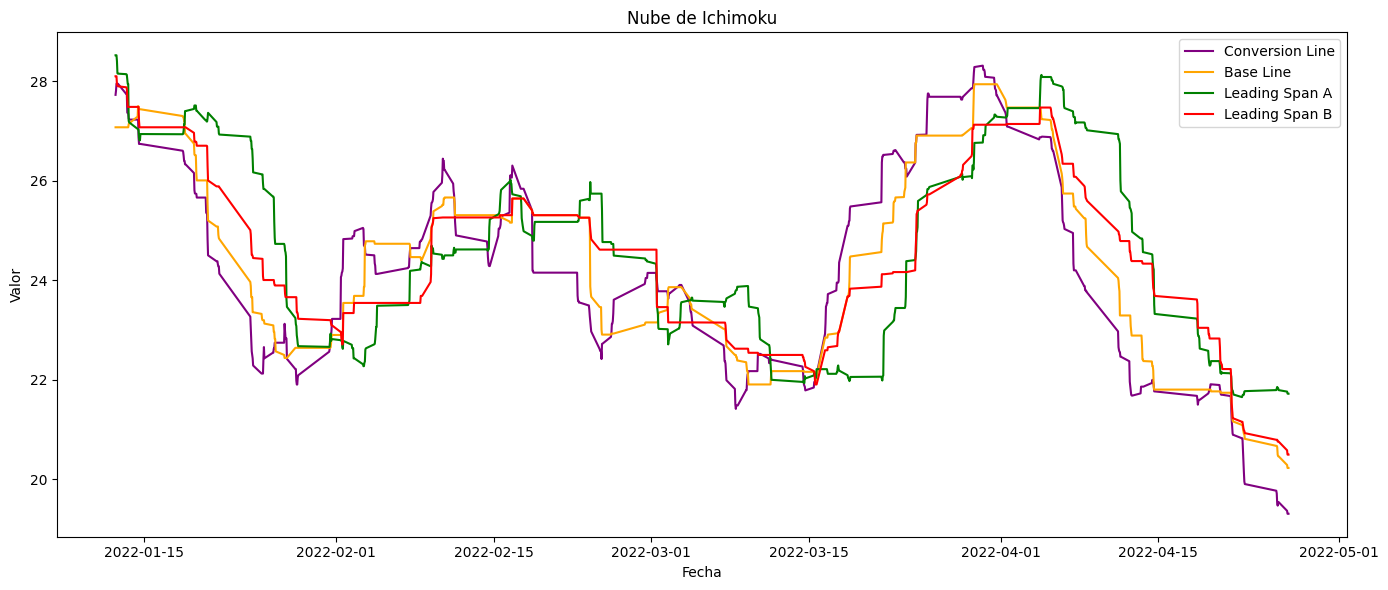

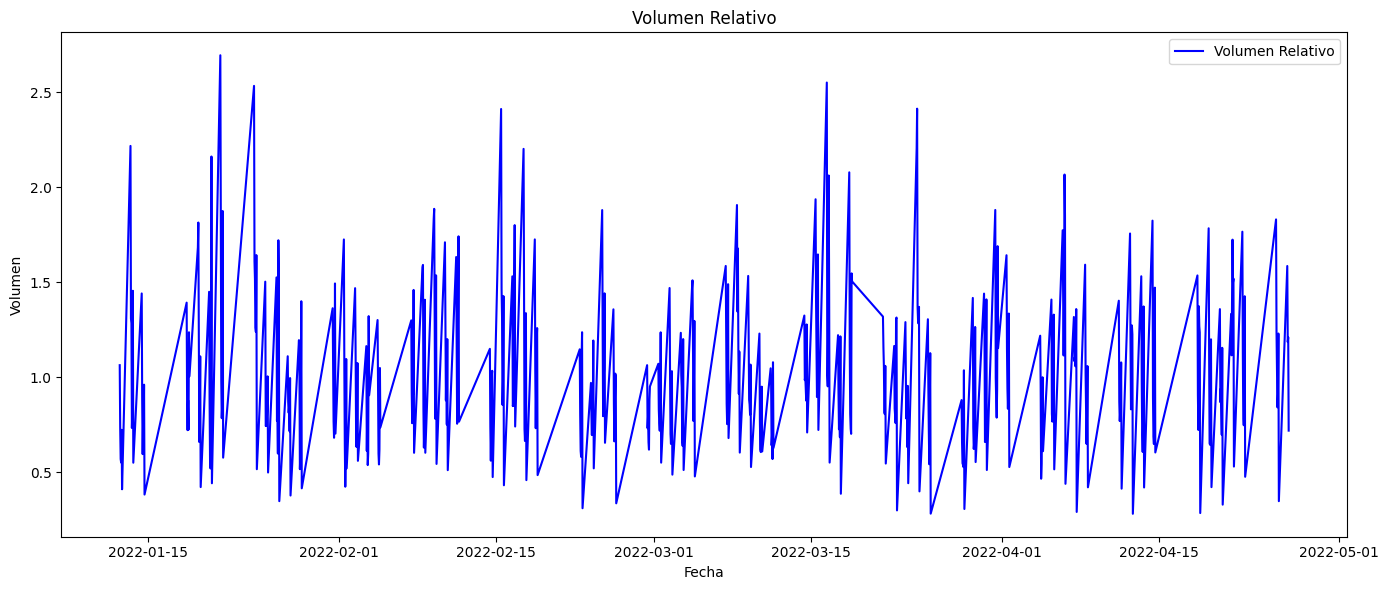

In [ ]:
import matplotlib.pyplot as plt


i = 6 # empresa
inicio = 0
final = 500


# Configuración del tamaño de la figura
plt.figure(figsize=(14, 20))

# Subgráfico inicio:final Precio de Cierre y SMAs
plt.subplot(6, 1, 1)
plt.plot(Data[i]['timestamp'][inicio:final], Data[i]['close'][inicio:final], label='Close Price', color='blue')
plt.plot(Data[i]['timestamp'][inicio:final], Data[i]['SMA_20'][inicio:final], label='SMA 20', color='orange')
plt.plot(Data[i]['timestamp'][inicio:final], Data[i]['SMA_50'][inicio:final], label='SMA 50', color='green')
plt.plot(Data[i]['timestamp'][inicio:final], Data[i]['SMA_200'][inicio:final], label='SMA 200', color='red')
plt.title('Precio de Cierre y SMAs')
plt.xlabel('Fecha')
plt.ylabel('Precio')
plt.legend()

# Subgráfico 2: EMA
plt.subplot(6, 1, 2)
plt.plot(Data[i]['timestamp'][inicio:final], Data[i]['EMA_20'][inicio:final], label='EMA 20', color='purple')
plt.plot(Data[i]['timestamp'][inicio:final], Data[i]['EMA_50'][inicio:final], label='EMA 50', color='magenta')
plt.title('Media Móvil Exponencial (EMA)')
plt.xlabel('Fecha')
plt.ylabel('EMA')
plt.legend()

# Subgráfico 3: RSI
plt.subplot(6, 1, 3)
plt.plot(Data[i]['timestamp'][inicio:final], Data[i]['RSI_14'][inicio:final], label='RSI 14', color='green')
plt.axhline(70, linestyle='--', alpha=0.5, color='red')  # Línea de sobrecompra
plt.axhline(30, linestyle='--', alpha=0.5, color='blue')  # Línea de sobreventa
plt.title('Índice de Fuerza Relativa (RSI)')
plt.xlabel('Fecha')
plt.ylabel('RSI')
plt.legend()

# Subgráfico 4: MACD
plt.subplot(6, 1, 4)
plt.plot(Data[i]['timestamp'][inicio:final], Data[i]['MACD'][inicio:final], label='MACD', color='blue')
plt.plot(Data[i]['timestamp'][inicio:final], Data[i]['MACD_signal'][inicio:final], label='Signal Line', color='orange')
plt.bar(Data[i]['timestamp'][inicio:final], Data[i]['MACD_diff'][inicio:final], label='MACD Diff', color='gray', alpha=0.3)
plt.title('MACD')
plt.xlabel('Fecha')
plt.ylabel('MACD')
plt.legend()

# Subgráfico 5: Bandas de Bollinger
plt.subplot(6, 1, 5)
plt.plot(Data[i]['timestamp'][inicio:final], Data[i]['close'][inicio:final], label='Close Price', color='blue')
plt.plot(Data[i]['timestamp'][inicio:final], Data[i]['Bollinger_High'][inicio:final], label='Bollinger High', color='orange')
plt.plot(Data[i]['timestamp'][inicio:final], Data[i]['Bollinger_Low'][inicio:final], label='Bollinger Low', color='red')
plt.title('Bandas de Bollinger')
plt.xlabel('Fecha')
plt.ylabel('Precio')
plt.legend()

# Subgráfico 6: ADX y DI
plt.subplot(6, 1, 6)
plt.plot(Data[i]['timestamp'][inicio:final], Data[i]['ADX'][inicio:final], label='ADX', color='purple')
plt.plot(Data[i]['timestamp'][inicio:final], Data[i]['DI+'][inicio:final], label='DI+', color='green')
plt.plot(Data[i]['timestamp'][inicio:final], Data[i]['DI-'][inicio:final], label='DI-', color='red')
plt.title('ADX y DI')
plt.xlabel('Fecha')
plt.ylabel('ADX')
plt.legend()

plt.tight_layout()  # Ajusta los subgráficos para evitar solapamientos
plt.show()

# Puedes agregar más subgráficos para los siguientes indicadores:

# Subgráfico 7: Oscilador Estocástico
plt.figure(figsize=(14, 6))
plt.subplot(3, 1, 1)
plt.plot(Data[i]['timestamp'][inicio:final], Data[i]['Stoch_%K'][inicio:final], label='%K', color='blue')
plt.plot(Data[i]['timestamp'][inicio:final], Data[i]['Stoch_%D'][inicio:final], label='%D', color='orange')
plt.title('Oscilador Estocástico')
plt.xlabel('Fecha')
plt.ylabel('Valor')
plt.legend()

# Subgráfico 8: ATR
plt.subplot(3, 1, 2)
plt.plot(Data[i]['timestamp'][inicio:final], Data[i]['ATR'][inicio:final], label='ATR', color='purple')
plt.title('Average True Range (ATR)')
plt.xlabel('Fecha')
plt.ylabel('ATR')
plt.legend()

# Subgráfico 9: Tasa de Cambio (ROC)
plt.subplot(3, 1, 3)
plt.plot(Data[i]['timestamp'][inicio:final], Data[i]['ROC'][inicio:final], label='ROC', color='green')
plt.title('Tasa de Cambio (ROC)')
plt.xlabel('Fecha')
plt.ylabel('ROC')
plt.legend()

plt.tight_layout()  # Ajusta los subgráficos para evitar solapamientos
plt.show()

# Subgráfico 10: Oscilador de Chaikin
plt.figure(figsize=(14, 6))
plt.plot(Data[i]['timestamp'][inicio:final], Data[i]['Chaikin_Oscillator'][inicio:final], label='Chaikin Oscillator', color='orange')
plt.title('Oscilador de Chaikin')
plt.xlabel('Fecha')
plt.ylabel('Oscilador')
plt.legend()
plt.tight_layout()
plt.show()

# Subgráfico 1inicio:final Nube de Ichimoku
plt.figure(figsize=(14, 6))
plt.plot(Data[i]['timestamp'][inicio:final], Data[i]['Ichimoku_conversion_line'][inicio:final], label='Conversion Line', color='purple')
plt.plot(Data[i]['timestamp'][inicio:final], Data[i]['Ichimoku_base_line'][inicio:final], label='Base Line', color='orange')
plt.plot(Data[i]['timestamp'][inicio:final], Data[i]['Ichimoku_a'][inicio:final], label='Leading Span A', color='green')
plt.plot(Data[i]['timestamp'][inicio:final], Data[i]['Ichimoku_b'][inicio:final], label='Leading Span B', color='red')
plt.title('Nube de Ichimoku')
plt.xlabel('Fecha')
plt.ylabel('Valor')
plt.legend()
plt.tight_layout()
plt.show()

# Subgráfico 12: Volumen Relativo
plt.figure(figsize=(14, 6))
plt.plot(Data[i]['timestamp'][inicio:final], Data[i]['Volume_Relative'][inicio:final], label='Volumen Relativo', color='blue')
plt.title('Volumen Relativo')
plt.xlabel('Fecha')
plt.ylabel('Volumen')
plt.legend()
plt.tight_layout()
plt.show()

No ejecutar sin no se necesita. El siguiente código es para rellenar los huecos de instantes sin datos

In [ ]:
# Completo las horas en las que no hay negociación manteniendo el último dato
print('Datos cargados: ', len(Data))

# 1. Establecer 'timestamp' como índice y asegurarse de que está ordenado
Data.set_index('timestamp', inplace=True)
Data.sort_index(inplace=True)

# 2. Reindexar para incluir todas las horas posibles y rellenar con los últimos datos de 'close'
Data = Data.resample('1H').asfreq()  # Completar todas las horas
#Data = Data.resample('5T').asfreq()
Data['close'] = Data['close'].ffill()  # Rellenar 'close' con el último valor conocido

# 3. Rellenar 'open', 'high', y 'low' con el valor de 'close' en las horas completadas
Data['open'] = Data['open'].fillna(Data['close'])
Data['high'] = Data['high'].fillna(Data['close'])
Data['low'] = Data['low'].fillna(Data['close'])

# 4. Establecer 'volume' a 0 en las horas sin negociación
Data['volume'] = Data['volume'].fillna(0)

print('Datos completos: ', len(Data))
Data.head()

In [ ]:
Data.columns

In [ ]:
Data.loc['2024-01-01':'2024-01-02']

Representamos los valores

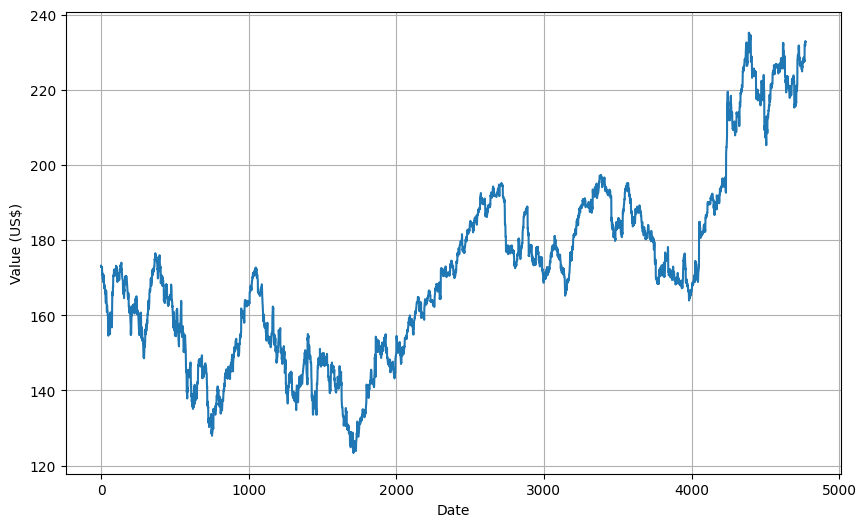

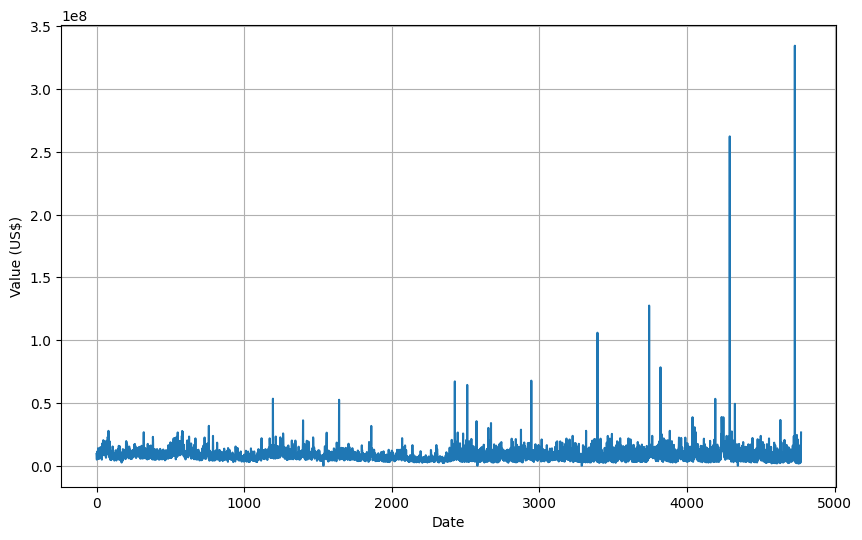

In [13]:
import matplotlib.pyplot as plt
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Date")
    plt.ylabel("Value (US$)")
    plt.grid(True)

i = 6

plt.figure(figsize=(10, 6))
plot_series(Data[0].index, Data[0]['close'])

plt.figure(figsize=(10, 6))
plot_series(Data[0].index, Data[0]['volume'])

Parámetros de las ventanas

In [14]:
## variables para la técnica de la ventana temporal
test_ratio = 0.1 # La proporción de datos que tomaremos para validar
sequence_length = np.ceil(7 * 22).astype(int) # La cantidad de datos de la ventana. En este caso un mes.
#sequence_length = np.ceil(30 * 24 * 12).astype(int) # La cantidad de datos de la ventana. En este caso un mes.
batch_size = 32
shuffle_buffer_size = 1000
horizon = np.ceil(7 * 5).astype(int) # Días en los que vamos a predecir el movimiento. En este caso una semana
#horizon = np.ceil(7 * 24 * 12).astype(int)
increment = 0.025 # Tanto por uno de subida o bajada del valor que buscamos
#increment = 0.015


Se hacen las ventanas

In [ ]:
#!pip install scikit-learn
#!pip install tqdm

In [15]:
from sklearn.preprocessing import StandardScaler
import copy
from tqdm import tqdm

max_abs_value = 0
max_volume = []

for e in range(len(Data)):

    max_volume.append(Data[e]['volume'].abs().max())

print('Calculados volumenes máximos ', max_volume)



print('Empezamos a hacer ventanas')

#volume_series = pd.Series(Data['volume'].replace(0, 0.01)) # Para evitar divisiones por cero

window_size = int(sequence_length + horizon)

# Elegimos las columnas con las que vamos a trabajar
# Pasamos a una lista en la que cada elemento es una lista
windows_2list = []
# Parámetro de stride
stride = 5  # Cambia este valor al número de datos que quieres saltarte entre ventanas
for j in tqdm(range(len(Data))):

    windows_2list.append([[pd.Series(Data[j]['close'])[i:i + window_size].values.tolist(),
                           pd.Series(Data[j]['volume'])[i:i + window_size].values.tolist(),
                           pd.Series(Data[j]['SMA_20'])[i:i + window_size].values.tolist(),
                           pd.Series(Data[j]['SMA_50'])[i:i + window_size].values.tolist(),
                           pd.Series(Data[j]['SMA_200'])[i:i + window_size].values.tolist(),
                           pd.Series(Data[j]['open'])[i:i + window_size].values.tolist(),
                           pd.Series(Data[j]['high'])[i:i + window_size].values.tolist(),
                           pd.Series(Data[j]['low'])[i:i + window_size].values.tolist(),
                           pd.Series(Data[j]['Bollinger_High'])[i:i + window_size].values.tolist(),
                           pd.Series(Data[j]['Bollinger_Low'])[i:i + window_size].values.tolist(),
                           pd.Series(Data[j]['RSI_14'])[i:i + window_size].values.tolist(),
                           pd.Series(Data[j]['MACD'])[i:i + window_size].values.tolist(),
                           pd.Series(Data[j]['MACD_signal'])[i:i + window_size].values.tolist()
                          ]
                         for i in range(0, len(pd.Series(Data[j]['close'])) - window_size + 1, stride)])



# windows_2list[empresa][ventana][input/label][instante][característica]

print('Ventanas hechas')
print('Script finalizado')
Audio('r2d2-squeaks1.mp3', autoplay=True)

Calculados volumenes máximos  [334440688, 41158505, 63127277, 62842668, 126228504, 17545794, 664763760, 140960993, 26783979, 38990849, 28685252]
Empezamos a hacer ventanas


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:35<00:00,  3.24s/it]

Ventanas hechas
Script finalizado


Transformación y normalización de los valores

In [ ]:
#backup = windows_2list.copy()
# Reestablezco los datos
windows_2list = backup.copy()

In [16]:



# Función para transformar cada ventana
def transform_2windows(windows_pair, sequence_length, horizon, increment):

    """
    Esta función toma una de las ventanas extraida de la secuencia temporal
    y cambia sus valores de por los incrementos en tanto por uno entre un dato y el anterior.
    También sustituye los últimos elementos por una variable que indica si en ellos ya habido
    un incremento superior al elegido.
    """

    # Convierto la ventana a un array de NumPy
    price_series = np.array(windows_pair[0])
    volume_series = np.array(windows_pair[1])
    SMA1_series = np.array(windows_pair[2])
    SMA2_series = np.array(windows_pair[3])
    SMA3_series = np.array(windows_pair[4])
    open_series = np.array(windows_pair[5])
    high_series = np.array(windows_pair[6])
    low_series = np.array(windows_pair[7])
    bol_high_series = np.array(windows_pair[8])
    bol_low_series = np.array(windows_pair[9])
    RSI_series = np.array(windows_pair[10])
    MACD_series = np.array(windows_pair[11])
    MACD_signal_series = np.array(windows_pair[12])

    # Se guarda el último elemento de la secuencia
    last_value = price_series[len(price_series)-(horizon+1)]

    # Se pasa de precios a variaciones respecto al valor anterior
    #transformed_price_series = np.zeros_like(price_series)
    #transformed_price_series[1:] = (price_series[1:] - price_series[:-1]) / price_series[:-1]

    # Se pasa de precios a variaciones respecto al primer valor
    #transformed_price_series = np.zeros_like(price_series)  # Crea un array de ceros con la misma forma que price_series
    transformed_price_series = (price_series - price_series[0]) / price_series[0]  # Calcula las variaciones respecto al primer valor


    #transformed_volume_series = np.zeros_like(volume_series)
    #transformed_volume_series[1:] = (volume_series[1:] - volume_series[:-1]) / volume_series[:-1]
    transformed_volume_series = volume_series

    # Convertimos las medias móviles
    #transformed_SMA1_series = np.zeros_like(SMA1_series)  # Crea un array de ceros
    transformed_SMA1_series = ((SMA1_series - SMA1_series[0]) / SMA1_series[0]) + ((SMA1_series[0] - price_series[0]) / price_series[0])
    #transformed_SMA2_series = np.zeros_like(SMA2_series)  # Crea un array de ceros
    transformed_SMA2_series = ((SMA2_series - SMA2_series[0]) / SMA2_series[0]) + ((SMA2_series[0] - price_series[0]) / price_series[0])
    #transformed_SMA3_series = np.zeros_like(SMA3_series)  # Crea un array de ceros
    transformed_SMA3_series = ((SMA3_series - SMA3_series[0]) / SMA3_series[0]) + ((SMA3_series[0] - price_series[0]) / price_series[0])

    # Convertimos los valores restantes de las velas
    #transformed_open_series = np.zeros_like(open_series)  # Crea un array de ceros
    transformed_open_series = ((open_series - open_series[0]) / open_series[0]) + ((open_series[0] - price_series[0]) / price_series[0])
    #transformed_high_series = np.zeros_like(high_series)  # Crea un array de ceros
    transformed_high_series = ((high_series - high_series[0]) / high_series[0]) + ((high_series[0] - price_series[0]) / price_series[0])
    #transformed_low_series = np.zeros_like(low_series)  # Crea un array de ceros
    transformed_low_series = ((low_series - low_series[0]) / low_series[0]) + ((low_series[0] - price_series[0]) / price_series[0])

    # Convertimos las bandas de Bollinger
    #transformed_bol_high_series = np.zeros_like(bol_high_series)  # Crea un array de ceros
    transformed_bol_high_series = ((bol_high_series - bol_high_series[0]) / bol_high_series[0]) + ((bol_high_series[0] - price_series[0]) / price_series[0])
    #transformed_bol_low_series = np.zeros_like(bol_low_series)  # Crea un array de ceros
    transformed_bol_low_series = ((bol_low_series - bol_low_series[0]) / bol_low_series[0]) + ((bol_low_series[0] - price_series[0]) / price_series[0])



    transformed_RSI_series = RSI_series

    transformed_MACD_series = MACD_series
    transformed_MACD_signal_series = MACD_signal_series

    # Se fija el límite que vamos a ver si en los horizon siguientes días se supera
    upper_limit = last_value * (1 + increment)
    touched = 0
    for i in range(sequence_length, sequence_length+horizon):
        if price_series[i] >= upper_limit:
            touched = 1

    # Formo listas de valores precio-volumen para cada instante de tiempo
    sequence = np.stack((transformed_price_series[:sequence_length],
                         transformed_volume_series[:sequence_length],
                         transformed_SMA1_series[:sequence_length],
                         transformed_SMA2_series[:sequence_length],
                         transformed_SMA3_series[:sequence_length],
                         transformed_open_series[:sequence_length],
                         transformed_high_series[:sequence_length],
                         transformed_low_series[:sequence_length],
                         transformed_bol_high_series[:sequence_length],
                         transformed_bol_low_series[:sequence_length],
                         transformed_RSI_series[:sequence_length],
                         transformed_MACD_series[:sequence_length],
                         transformed_MACD_signal_series[:sequence_length]
                        ),
                        axis=1)

    # Devolvemos una lista de dos listas y un entero, eliminando el horizonte
    return [sequence, touched]


# windows_2list[empresa][ventana][input/label][instante][característica]

print('Empieza la transformación')
for e in tqdm(range(len(windows_2list))): # Empresa

    # Se llama a la función para transformar las ventanas
    windows_2list[e] = [transform_2windows(windows_pair, sequence_length, horizon, increment)
                     for windows_pair in windows_2list[e]]

print('Transformación de precios hecha, calculando máximos')

max_abs_MACD = []
max_abs_value = []
for e in range(len(windows_2list)): # Empresa

    # Encontrar el valor absoluto máximo entre precios y medias móviles
    max_abs_value.append(0)
    max_abs_MACD.append(0)
    for v in tqdm(range(len(windows_2list[e]))): # Ventana

        for t in range(len(windows_2list[e][v][0])): # Instante t en ventana [1] son las labels

            for c in [0, 2, 3, 4, 5, 6, 7, 8, 9]: # Característica: precios y SMAs y velas y Bollinger

                #print('e=', e,' v=', v, ' c=', c,' t=', t)
                #print('Valor a comparar: ', windows_2list[e][v][0][t][c])
                if np.abs(windows_2list[e][v][0][t][c]) > max_abs_value[e]:
                    max_abs_value[e] = np.abs(windows_2list[e][v][0][t][c])
                    if max_abs_value[e] >10:
                        print('Nuevo máximo: ', np.abs(windows_2list[e][v][0][t][c]))
                        print('e=', e, ' v=', v, ' t=', t, ' c=', c)

            for c in [11, 12]:  # Característica: MACD

                if np.abs(windows_2list[e][v][0][t][c]) > max_abs_MACD[e]:
                    max_abs_MACD[e] = np.abs(windows_2list[e][v][0][t][c])


    #max_abs_value.append(max_abs_value[e])
    #max_abs_MACD.append(max_abs_MACD[e])

"""
max_abs_value = []
max_abs_MACD = []

for e in range(len(windows_2list)):  # Empresa
    data_array = np.array([win[0] for win in windows_2list[e]])  # Convertimos ventanas a array
    max_abs_value.append(np.max(np.abs(data_array[:, :, [0, 2, 3, 4, 5, 6, 7, 8, 9]])))  # Precios, SMAs, Bollinger
    max_abs_MACD.append(np.max(np.abs(data_array[:, :, [11, 12]])))  # MACD y MACD_signal
"""
print('Calculados max_abs_values ', max_abs_value)
print('Calculados max_abs_MACD ', max_abs_MACD)

max_abs_value = np.max(max_abs_value)
max_abs_MACD = np.max(max_abs_MACD)

print('Máximo precio: ', max_abs_value)
print('Máximo MACD: ', max_abs_MACD)

volumes = []
for e in range(len(windows_2list)):
    print('Ventanas de empresa ', e, ' ', len(windows_2list[e]))

    """
    for v in range(len(windows_2list[e])):
        # Normalizar la primera columna (precios) de la secuencia en la ventana
        windows_2list[e][v][0][:, 0] /= max_abs_value
        windows_2list[e][v][0][:, 2] /= max_abs_value
        windows_2list[e][v][0][:, 3] /= max_abs_value
        windows_2list[e][v][0][:, 4] /= max_abs_value
        windows_2list[e][v][0][:, 5] /= max_abs_value
        windows_2list[e][v][0][:, 6] /= max_abs_value
        windows_2list[e][v][0][:, 7] /= max_abs_value
        windows_2list[e][v][0][:, 8] /= max_abs_value
        windows_2list[e][v][0][:, 9] /= max_abs_value
        windows_2list[e][v][0][:, 10] /= 100
        windows_2list[e][v][0][:, 11] /= max_abs_MACD
        windows_2list[e][v][0][:, 12] /= max_abs_MACD
        volumes.append(windows_2list[e][v][0][:, 1]/ max_volume[e])
        windows_2list[e][v][0][:, 1] = np.power(volumes[e], 1/7)
    """
    data_array = np.array([win[0] for win in windows_2list[e]])  # Convertir ventanas a array

    # Normalizar precios, SMAs, y otros valores relacionados
    data_array[:, :, [0, 2, 3, 4, 5, 6, 7, 8, 9]] /= max_abs_value

    # Normalizar volúmenes
    data_array[:, :, 1] /= max_volume[e]
    data_array[:, :, 1] = np.power(data_array[:, :, 1], 1/7)

    # Actualizar las ventanas normalizadas
    for v, win in enumerate(windows_2list[e]):
        windows_2list[e][v][0] = data_array[v]


print('Precios normalizados, volúmenes escalados')

print('Script finalizado')
Audio('r2d2-squeaks1.mp3', autoplay=True)

Empieza la transformación


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:10<00:00,  1.09it/s]


Transformación de precios hecha, calculando máximos


100%|█████████████████████████████████████████████████████████████████████████████| 1224/1224 [00:05<00:00, 234.84it/s]


Calculados max_abs_values  [0.2640258272092601, 0.7037398685885013, 0.2258963558739765, 0.27595797845506886, 0.3996134040704702, 0.28802099252290453, 0.6192923711558292, 0.7570399335373882, 0.33732900587143916, 0.5769729928093688, 0.877737754472006]
Calculados max_abs_MACD  [12.710136861794211, 41.0234147344259, 16.44518022546572, 7.928654635047479, 13.396432438933147, 12.133156969571473, 12.589428421708263, 3.520214193758143, 14.140876027417477, 16.83021075066847, 60.369717336252506]
Máximo precio:  0.877737754472006
Máximo MACD:  60.369717336252506
Ventanas de empresa  0   917
Ventanas de empresa  1   930
Ventanas de empresa  2   934
Ventanas de empresa  3   1214
Ventanas de empresa  4   940
Ventanas de empresa  5   1197
Ventanas de empresa  6   950
Ventanas de empresa  7   1301
Ventanas de empresa  8   937
Ventanas de empresa  9   950
Ventanas de empresa  10   1224
Precios normalizados, volúmenes escalados
Script finalizado



Visualización de las ventanas

In [ ]:
import matplotlib.pyplot as plt

def visualize_window(windows_2list, empresa_idx, ventana_idx):
    """
    Visualiza las características de una ventana específica de una empresa en windows_2list.

    Args:
        windows_2list (list): Lista de empresas con sus ventanas.
        empresa_idx (int): Índice de la empresa a visualizar.
        ventana_idx (int): Índice de la ventana dentro de esa empresa.

    """
    # Verifica si los índices son válidos
    if empresa_idx >= len(windows_2list):
        print(f"Índice de empresa inválido: {empresa_idx}. Solo hay {len(windows_2list)} empresas.")
        return

    empresa_windows = windows_2list[empresa_idx]

    if ventana_idx >= len(empresa_windows):
        print(f"Índice de ventana inválido: {ventana_idx}. Solo hay {len(empresa_windows)} ventanas para la empresa {empresa_idx}.")
        return

    # Obtén la ventana
    window = empresa_windows[ventana_idx][0]

    # Lista de nombres de características (ajustar según tu estructura)
    features_names = ['Close', 'Volume', 'SMA_20', 'SMA_50', 'SMA_200',
                      'Open', 'High', 'Low', 'Bollinger High', 'Bollinger Low',
                      'RSI_14', 'MACD', 'MACD Signal']

    # windows_2list[empresa][ventana][input/label][instante][característica]

    # Transponer los datos para tener las características separadas
    window = list(map(list, zip(*window)))  # Transposición de la lista

    # Visualizar cada característica
    num_features = len(window)
    print('len(window) = ', num_features)

    fig, axs = plt.subplots(num_features, 1, figsize=(10, 2 * num_features))
    if num_features == 1:
        axs = [axs]  # Asegurar que axs sea iterable

    for i, ax in enumerate(axs):
        if i < len(features_names):  # Verifica que haya un nombre de característica para este índice
            ax.plot(window[i], label=features_names[i])
            ax.set_title(features_names[i])
            ax.legend()
        else:
            ax.plot(window[i], label=f'Feature {i}')
            ax.set_title(f'Feature {i}')
            ax.legend()

    plt.tight_layout()
    plt.show()

# Ejemplo de uso
visualize_window(windows_2list, empresa_idx=6, ventana_idx=1930)


Índice de ventana inválido: 1930. Solo hay 826 ventanas para la empresa 6.


Número de ventanas:  934


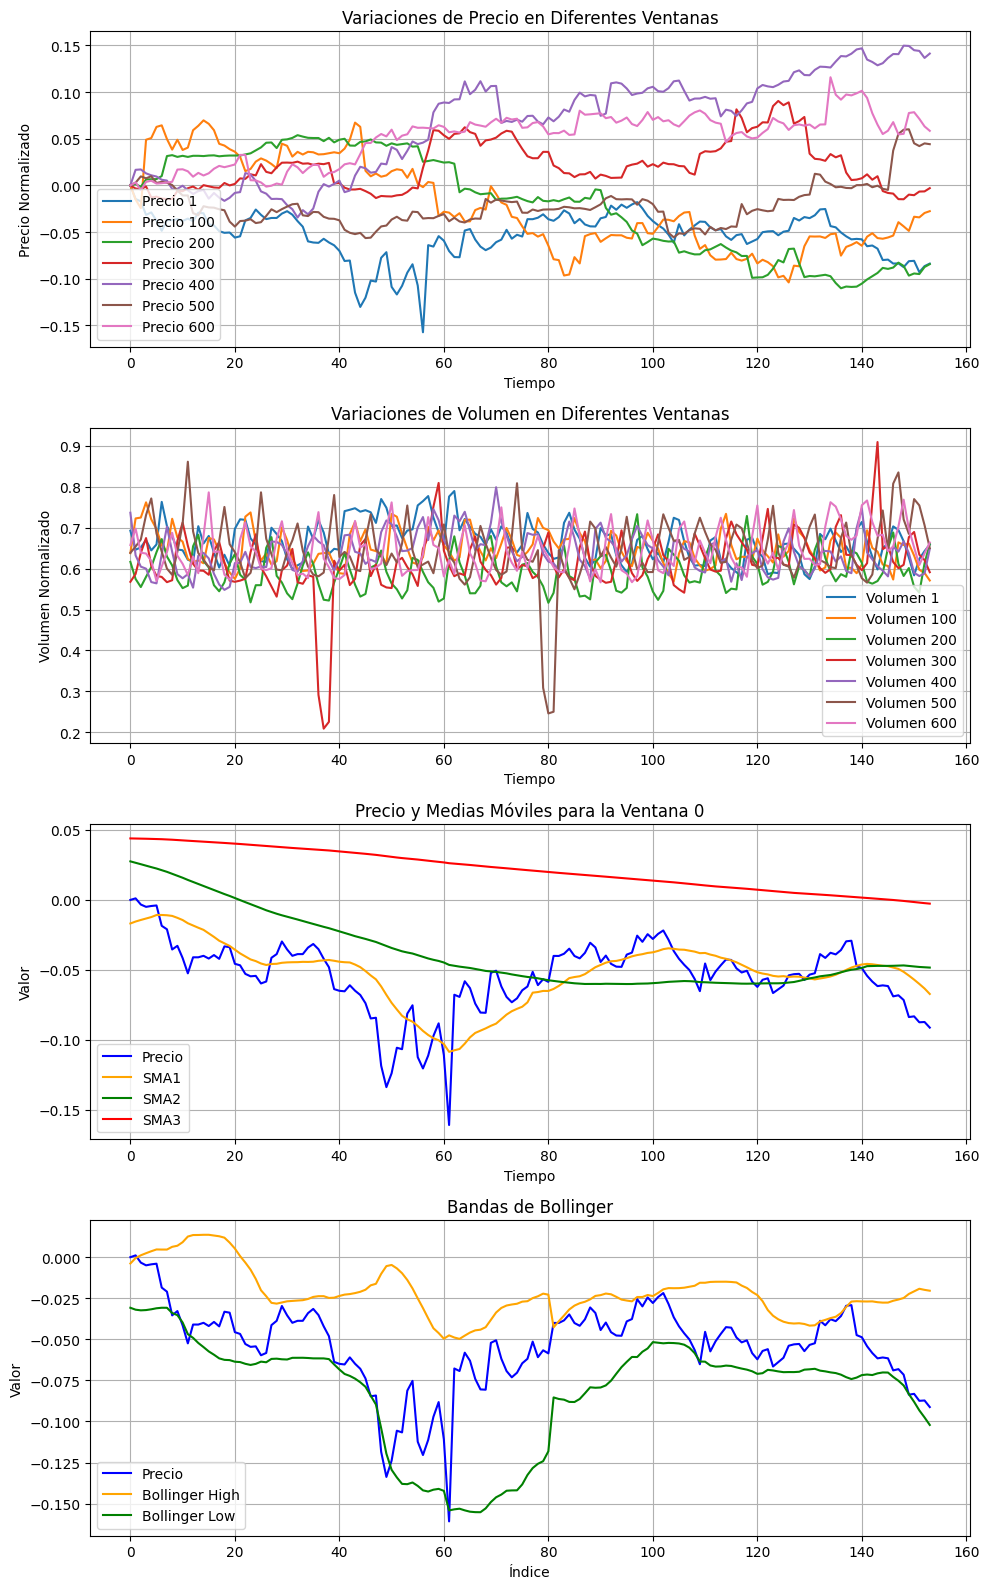

In [17]:
import numpy as np
import matplotlib.pyplot as plt

# Creación de la figura con tres subplots
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(10, 16))


empresa = 2
print('Número de ventanas: ', len(windows_2list[empresa]))

# Graficar cada ventana
for i in [1, 100, 200, 300, 400, 500, 600]:
    ventana = windows_2list[empresa][i][:-1]  # Asegúrate de que esto no deja ventana vacía
    ventana = ventana[0]

    precio = []
    volumen = []

    for elemento in ventana:
        precio.append(elemento[0])
        volumen.append(elemento[1])

    # Graficar precios en el primer subplot (ax1)
    ax1.plot(precio, label='Precio ' + str(i))  # Graficar los precios

    # Graficar volúmenes en el segundo subplot (ax2)
    ax2.plot(volumen, label='Volumen ' + str(i))  # Graficar los volúmenes

# Selecciona una ventana para graficar precios y medias móviles
selected_window_index = 0  # Cambia este índice según tus necesidades
selected_window = windows_2list[empresa][selected_window_index][0]

# Extraer precios y medias móviles
selected_prices = selected_window[:, 0]
SMA1 = selected_window[:, 2]  # Media móvil 1
SMA2 = selected_window[:, 3]  # Media móvil 2
SMA3 = selected_window[:, 4]  # Media móvil 3

BOLH = selected_window[:, 8]  # Bollinger high
BOLL = selected_window[:, 9]  # Bollinger low

# Graficar precios y medias móviles en el tercer subplot (ax3)
ax3.plot(selected_prices, label='Precio', color='blue')
ax3.plot(SMA1, label='SMA1', color='orange')
ax3.plot(SMA2, label='SMA2', color='green')
ax3.plot(SMA3, label='SMA3', color='red')

ax1.set_title('Variaciones de Precio en Diferentes Ventanas')
ax1.set_xlabel('Tiempo')
ax1.set_ylabel('Precio Normalizado')
ax1.legend()
ax1.grid(True)

ax2.set_title('Variaciones de Volumen en Diferentes Ventanas')
ax2.set_xlabel('Tiempo')
ax2.set_ylabel('Volumen Normalizado')
ax2.legend()
ax2.grid(True)

ax3.set_title('Precio y Medias Móviles para la Ventana ' + str(selected_window_index))
ax3.set_xlabel('Tiempo')
ax3.set_ylabel('Valor')
ax3.legend()
ax3.grid(True)

# Graficar precios y medias móviles en el cuarto subplot (ax4)
ax4.plot(selected_prices[selected_window_index: selected_window_index + sequence_length], label='Precio', color='blue')
ax4.plot(BOLH[selected_window_index: selected_window_index + sequence_length], label='Bollinger High', color='orange')
ax4.plot(BOLL[selected_window_index: selected_window_index + sequence_length], label='Bollinger Low', color='green')
ax4.set_title('Bandas de Bollinger')
ax4.set_xlabel('Índice')
ax4.set_ylabel('Valor')
ax4.legend()
ax4.grid(True)

# Ajustar el layout para evitar superposiciones
plt.tight_layout()

# Mostrar los gráficos
plt.show()

Estadísticas de los datos

In [14]:
import numpy as np
import pandas as pd

empresa = 5

# Extraer precios y volúmenes de todas las ventanas
all_prices = np.concatenate([window[0][:, 0] for window in windows_2list[empresa]])  # Precios
all_volumes = np.concatenate([window[0][:, 1] for window in windows_2list[empresa]])  # Volúmenes

# Crear DataFrames de pandas para obtener estadísticas
prices_df = pd.DataFrame(all_prices, columns=['Precios'])
volumes_df = pd.DataFrame(all_volumes, columns=['Volúmenes'])

# Obtener estadísticas descriptivas
price_stats = prices_df.describe()
volume_stats = volumes_df.describe()

print("Estadísticas de los precios:")
print(price_stats)

print("\nEstadísticas de los volúmenes:")
print(volume_stats)

Estadísticas de los precios:
             Precios
count  826980.000000
mean        0.022270
std         0.049165
min        -0.092072
25%        -0.010621
50%         0.015630
75%         0.051499
max         0.241662

Estadísticas de los volúmenes:
           Volúmenes
count  826980.000000
mean        0.590861
std         0.065102
min         0.183303
25%         0.547024
50%         0.579347
75%         0.622985
max         1.000000


Histograma de los datos

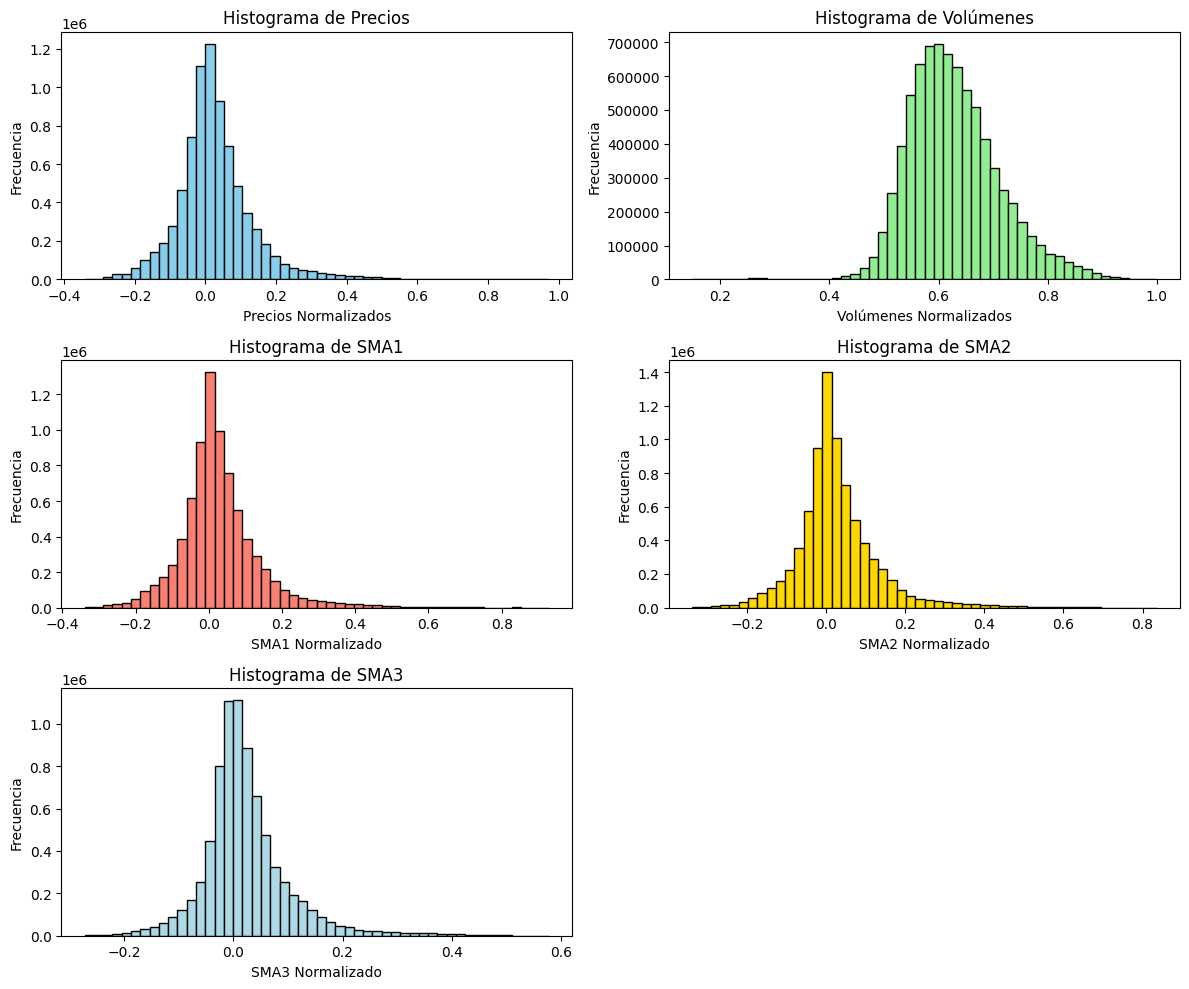

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

empresa = 9

# Extraer precios y volúmenes de todas las ventanas
all_prices = np.concatenate([window[0][:, 0] for empresa in windows_2list for window in empresa])
all_volumes = np.concatenate([window[0][:, 1] for empresa in windows_2list for window in empresa])


# Eliminar datos que sean cero
all_prices = all_prices[all_prices != 0]
all_volumes = all_volumes[all_volumes != 0]

# Extraer las medias móviles de todas las ventanas
all_SMA1 = np.concatenate([window[0][:, 2] for empresa in windows_2list for window in empresa])  # SMA1
all_SMA2 = np.concatenate([window[0][:, 3] for empresa in windows_2list for window in empresa])  # SMA2
all_SMA3 = np.concatenate([window[0][:, 4] for empresa in windows_2list for window in empresa])  # SMA3

# Crear histogramas
plt.figure(figsize=(12, 10))

# Histograma de precios
plt.subplot(3, 2, 1)  # 3 filas, 2 columnas, 1ª posición
plt.hist(all_prices, bins=50, color='skyblue', edgecolor='black')
plt.title('Histograma de Precios')
plt.xlabel('Precios Normalizados')
plt.ylabel('Frecuencia')

# Histograma de volúmenes
plt.subplot(3, 2, 2)  # 3 filas, 2 columnas, 2ª posición
plt.hist(all_volumes, bins=50, color='lightgreen', edgecolor='black')
plt.title('Histograma de Volúmenes')
plt.xlabel('Volúmenes Normalizados')
plt.ylabel('Frecuencia')

# Histograma de SMA1
plt.subplot(3, 2, 3)  # 3 filas, 2 columnas, 3ª posición
plt.hist(all_SMA1, bins=50, color='salmon', edgecolor='black')
plt.title('Histograma de SMA1')
plt.xlabel('SMA1 Normalizado')
plt.ylabel('Frecuencia')

# Histograma de SMA2
plt.subplot(3, 2, 4)  # 3 filas, 2 columnas, 4ª posición
plt.hist(all_SMA2, bins=50, color='gold', edgecolor='black')
plt.title('Histograma de SMA2')
plt.xlabel('SMA2 Normalizado')
plt.ylabel('Frecuencia')

# Histograma de SMA3
plt.subplot(3, 2, 5)  # 3 filas, 2 columnas, 5ª posición
plt.hist(all_SMA3, bins=50, color='lightblue', edgecolor='black')
plt.title('Histograma de SMA3')
plt.xlabel('SMA3 Normalizado')
plt.ylabel('Frecuencia')

plt.tight_layout()
plt.show()


In [ ]:
%store windows_2list

Stored 'windows_2list' (list)


**Para guardar y recuperar variables, dentro de jupyter:**


%store variable

%store -r variable

**Para guardar archivo en json:**


```
# Guardar
import json
variable = {"key": 42}
with open('variable.json', 'w') as f:
    json.dump(variable, f)
```
```
# Recuperar
import json
with open('variable.json', 'r') as f:
    variable = json.load(f)
```




In [ ]:
import pickle
import numpy as np
import os

full_path_pkl = 'windows_2list.pkl'

with open(full_path_pkl, 'wb') as f:
    pickle.dump(windows_2list, f)

print(f"Variable guardada en {full_path_pkl} con pickle.")


Variable guardada en windows_2list.pkl con pickle.


In [ ]:
# Para cargar de nuevo:
full_path_pkl = 'windows_2list.pkl'
with open(full_path_pkl, 'rb') as f:
    loaded_windows_2list = pickle.load(f)

print("\nVariable cargada con pickle:")
print(loaded_windows_2list[0]['data'])
print(type(loaded_windows_2list[0]['data']))

Se separan los datos de entrada X de las etiquetas de salida y.

Para ello primero se cortan en entrenamiento y validación por empresa y luego se juntan.

In [18]:

porcentaje = 0.9
train_sequences = []
test_sequences = []
train_labels = []
test_labels = []
test_lengths = []

# windows_2list[empresa][ventana][input/label][instante][característica]
for e in range(len(windows_2list)): # Para cada empresa

    sub_sequences = []
    sub_labels = []
    cut = np.ceil(len(windows_2list[e]) * porcentaje).astype(int)
    for window, label in windows_2list[e]:
        sub_sequences.append(window)  # La ventana transformada
        sub_labels.append(label)       # La etiqueta (si se tocó el límite)

    sub_train_sequences = sub_sequences[:cut]
    sub_test_sequences = sub_sequences[cut:]
    sub_train_labels = sub_labels[:cut]
    sub_test_labels = sub_labels[cut:]

    test_lengths.append(len(sub_test_sequences))

    train_sequences.extend(sub_train_sequences)
    test_sequences.extend(sub_test_sequences)
    train_labels.extend(sub_train_labels)
    test_labels.extend(sub_test_labels)

train_sequences = np.array(train_sequences)
test_sequences = np.array(test_sequences)
train_labels = np.array(train_labels)
test_labels = np.array(test_labels)


print(train_sequences[300])
print(train_labels[300])
print('Script finalizado')
print('Longitudes de los test ', test_lengths)

[[ 0.00000000e+00  5.72018967e-01 -1.19422852e-02 ...  5.86023197e+01
  -2.12412196e+00 -2.69357043e+00]
 [-6.51690586e-03  6.06493884e-01 -1.25134686e-02 ...  4.86101180e+01
  -2.09121318e+00 -2.68526206e+00]
 [-2.52623342e-03  6.17019842e-01 -1.19106996e-02 ...  5.36562863e+01
  -2.05577915e+00 -2.67657954e+00]
 ...
 [-1.41803213e-01  6.27308206e-01 -1.33715320e-01 ...  2.45032755e+01
  -2.54279559e+00 -1.78912768e+00]
 [-1.43204477e-01  5.95177794e-01 -1.35708958e-01 ...  2.64826594e+01
  -2.59173160e+00 -1.80019808e+00]
 [-1.40031272e-01  5.64463555e-01 -1.36959206e-01 ...  3.33277112e+01
  -2.63747873e+00 -1.81174678e+00]]
1
Script finalizado
Longitudes de los test  [91, 93, 93, 121, 94, 119, 95, 130, 93, 95, 122]


Se separan los datos en el conjunto de entrenamiento y en el de validación

Comprobación de equilibrio entre clases

In [19]:
print('Número de casos: ', len(train_labels) + len(test_labels))
print('Casos positivos: ', sum(train_labels) + sum(test_labels))
print('Relación de positivos: ', ((sum(train_labels) + sum(test_labels))/(len(train_labels) + len(test_labels)))*100, '%')
print('Umbral de incremento estudiado: ', increment*100, '%')
print('Longitud de la secuencia: ', sequence_length)
print('Longitud del horizonte: ', horizon)
print('')
print('Conjunto de entrenamiento')
print('Número de casos: ', len(train_labels))
print('Casos positivos: ', sum(train_labels))
print('Relación de positivos: ', (sum(train_labels)/len(train_labels))*100, '%')
print('')
print('Conjunto de test')
print('Número de casos: ', len(test_labels))
print('Casos positivos: ', sum(test_labels))
print('Relación de positivos: ', (sum(test_labels)/len(test_labels))*100, '%')





Número de casos:  11494
Casos positivos:  5700
Relación de positivos:  49.59109100400209 %
Umbral de incremento estudiado:  2.5 %
Longitud de la secuencia:  154
Longitud del horizonte:  35

Conjunto de entrenamiento
Número de casos:  10348
Casos positivos:  5150
Relación de positivos:  49.76807112485505 %

Conjunto de test
Número de casos:  1146
Casos positivos:  550
Relación de positivos:  47.99301919720768 %


Wavelets

In [17]:
if colab:
    !pip install PyWavelets
import pywt
#pywt.families()
#pywt.wavelist()

Wavelet de 3 niveles

In [20]:
import pywt
import numpy as np

def pad_coefficients(coeffs, max_length):
    """Rellena los coeficientes más pequeños con ceros para que tengan la misma longitud."""
    return np.pad(coeffs, (0, max_length - len(coeffs)), mode='constant')

def interpolate_coefficients(coeffs, max_length):
    """Interpola los coeficientes para que tengan la misma longitud."""
    original_length = len(coeffs)
    x_old = np.arange(original_length)
    x_new = np.linspace(0, original_length - 1, max_length)  # Nuevos puntos distribuidos uniformemente
    return np.interp(x_new, x_old, coeffs)

def repeat_coefficients(coeffs, max_length):
    """
    Expande los coeficientes manteniendo el último valor hasta el siguiente.

    Args:
    - coeffs (list or np.array): Coeficientes originales.
    - max_length (int): Longitud máxima a la que expandir la lista de coeficientes.

    Returns:
    - np.array: Lista de coeficientes expandida con el valor anterior repetido.
    """
    original_length = len(coeffs)

    # Índices originales
    x_old = np.arange(original_length)

    # Índices nuevos, distribuidos uniformemente
    x_new = np.linspace(0, original_length - 1, max_length)

    # Para cada nuevo índice, buscamos el índice más grande de x_old que sea menor o igual
    idx = np.searchsorted(x_old, x_new, side='right') - 1

    # Aseguramos que no haya índices negativos (puede suceder para el primer valor)
    idx = np.clip(idx, 0, original_length - 1)

    # Usamos los índices para repetir los valores de los coeficientes
    data_new = coeffs[idx]

    return data_new

def apply_wavelet_transform(ventana, wavelet='db4'):
    # Aplica la wavelet separadamente a los precios y volúmenes
    prices = ventana[:, 0]
    volumes = ventana[:, 1]

    # Aplicar la transformada wavelet a los precios y volúmenes
    coeffs_prices = pywt.wavedec(prices, wavelet, level=3)  # Obtenemos [A_3, D_3, D_2, D_1]
    coeffs_volumes = pywt.wavedec(volumes, wavelet, level=3)  # Obtenemos [A_3, D_3, D_2, D_1]

    # Mantener los coeficientes de aproximación (A) y detalles (D)
    A_p, D_p3, D_p2, D_p1 = coeffs_prices
    A_v, D_v3, D_v2, D_v1 = coeffs_volumes

    # Encontrar la longitud máxima de los coeficientes
    #max_length = max(len(c) for c in coeffs_prices + coeffs_volumes)

    max_length = len(ventana)

    # Interpolar todos los coeficientes para que tengan la misma longitud
    A_p, D_p3, D_p2, D_p1 = [interpolate_coefficients(c, max_length) for c in coeffs_prices]
    A_v, D_v3, D_v2, D_v1 = [interpolate_coefficients(c, max_length) for c in coeffs_volumes]

    # Si en lugar de interpolar queremos mantener el último valor
    #A_p, D_p3, D_p2, D_p1 = [repeat_coefficients(c, max_length) for c in coeffs_prices]
    #A_v, D_v3, D_v2, D_v1 = [repeat_coefficients(c, max_length) for c in coeffs_volumes]

    # Combina los coeficientes en un solo array de 8 características
    transformed_sequence = np.stack([A_p, D_p3, D_p2, D_p1, A_v, D_v3, D_v2, D_v1], axis=-1)

    return transformed_sequence

# Aplica la transformada a las secuencias de entrenamiento y prueba
train_sequences_wavelet = np.array([apply_wavelet_transform(seq) for seq in train_sequences])
test_sequences_wavelet = np.array([apply_wavelet_transform(seq) for seq in test_sequences])

print('Shape original: ', train_sequences.shape)  # Forma original (6148, 420, 2)
print('Shape wavelets: ', train_sequences_wavelet.shape)  # Forma transformada esperada (6148, 420, 8)

Audio('r2d2-squeaks1.mp3', autoplay=True)

Shape original:  (10348, 154, 13)
Shape wavelets:  (10348, 154, 8)


Visualización

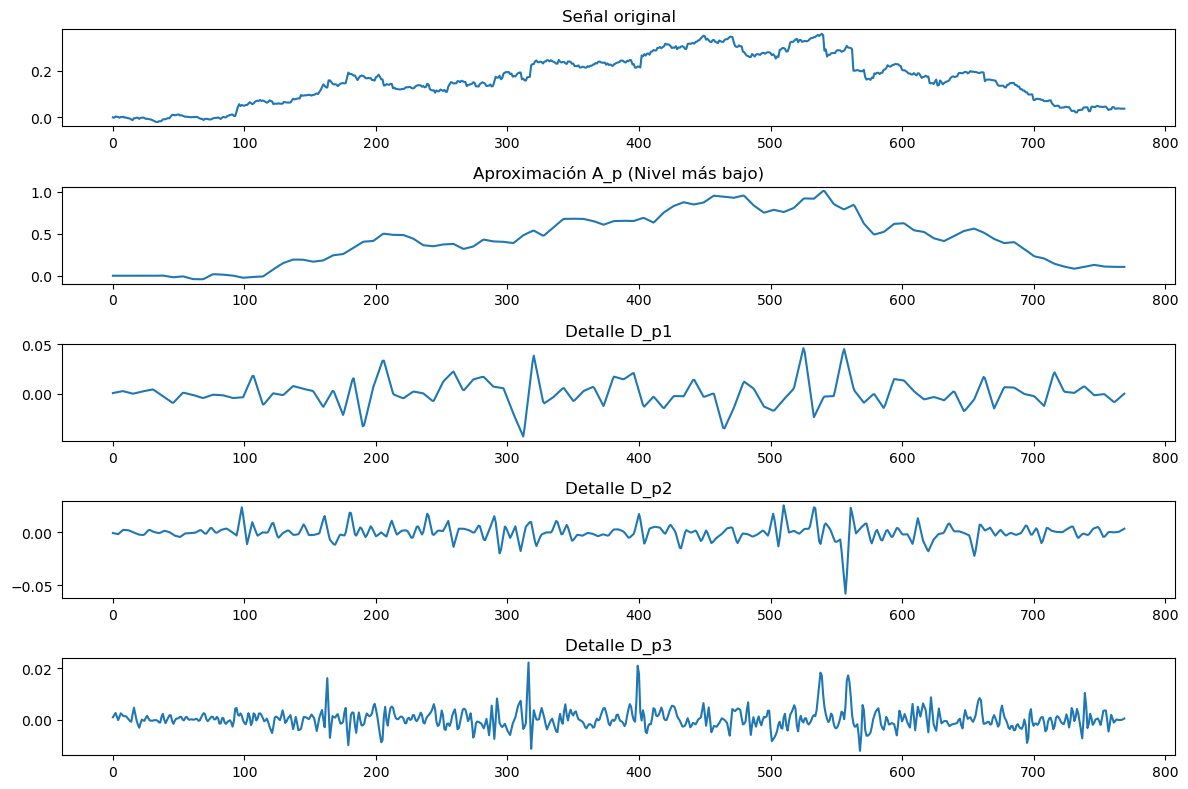

In [ ]:
import matplotlib.pyplot as plt

#print(train_sequences_wavelet[1000][0])
#print(len(train_sequences_wavelet[1000]))

coeficientes = []
for ejemplo in train_sequences_wavelet:
    coeficientes.append([instante[:4] for instante in ejemplo])


#print(coeficientes[1000][0])


ejemplo = 5000

# Señal original de la secuencia de entrenamiento
data = train_sequences[ejemplo][:, 0]


# Gráfico de la señal original
plt.figure(figsize=(12, 8))
plt.subplot(len(coeficientes[ejemplo][0]) + 1, 1, 1)
plt.plot(data)
plt.title('Señal original')



coef1 = []
coef2 = []
coef3 = []
coef4 = []

for i in range(len(coeficientes[ejemplo])):

    coef1.append(coeficientes[ejemplo][i][0])
    coef2.append(coeficientes[ejemplo][i][1])
    coef3.append(coeficientes[ejemplo][i][2])
    coef4.append(coeficientes[ejemplo][i][3])

coef = [coef1, coef2, coef3, coef4]

for j in range(4):

    plt.subplot(len(coeficientes[ejemplo][0]) + 1, 1, j + 2)
    plt.plot(coef[j])

    if j == 0:
        plt.title('Aproximación A_p (Nivel más bajo)')
    else:
        plt.title(f'Detalle D_p{j}')

plt.tight_layout()
plt.show()



Insertamos las componentes de los wavelets en el formato que espera el modelo

In [21]:


def build_sequences(windows_original, windows_wavelet):

    sequences = []
    print('Longitud original: ', len(windows_original))
    print('Longitud wavelets: ', len(windows_wavelet))
    for w in range(len(windows_original)):
        #print('Número de instantes: ', len(windows_original[w]))
        new_window = []
        for inst in range(len(windows_original[w])):

            new_inst = [windows_original[w][inst][0], # Precio
                        windows_wavelet[w][inst][0],  # Ajuste
                        windows_wavelet[w][inst][1],  # Detalle1
                        windows_wavelet[w][inst][2],  # Detalle2
                        windows_wavelet[w][inst][3],  # Detalle3
                        windows_original[w][inst][1], # Volumen
                        windows_original[w][inst][2], # SMA1
                        windows_original[w][inst][3], # SMA2
                        windows_original[w][inst][4], # SMA3
                        windows_original[w][inst][5], # Open
                        windows_original[w][inst][6], # High
                        windows_original[w][inst][7], # Low
                        windows_original[w][inst][8], # Bollinger high
                        windows_original[w][inst][9], # Bollinger low
                        windows_original[w][inst][10], # RSI
                        windows_original[w][inst][11], # MACD
                        windows_original[w][inst][12]  # MACD signal
                       ]
            new_window.append(new_inst)
        sequences.append(new_window)
    #print('Shape de retorno: ', sequences.shape)
    return np.array(sequences)

train_input = build_sequences(train_sequences, train_sequences_wavelet)
test_input = build_sequences(test_sequences, test_sequences_wavelet)

print('Remodelación completada')
print(train_input.shape)
#print(salida[2500])


# Aplica la transformada a las secuencias de entrenamiento y prueba
#train_sequences_wavelet = np.array([apply_wavelet_transform(seq) for seq in train_sequences])
#test_sequences_wavelet = np.array([apply_wavelet_transform(seq) for seq in test_sequences])


Audio('r2d2-squeaks1.mp3', autoplay=True)

Longitud original:  10348
Longitud wavelets:  10348
Longitud original:  1146
Longitud wavelets:  1146
Remodelación completada
(10348, 154, 17)


Liberamos memoria

In [ ]:
import sys

# Crear una lista de tuplas con el nombre de la variable y su tamaño en memoria
variables_info = [(var_name, sys.getsizeof(globals()[var_name]))
                  for var_name in globals()
                  if not var_name.startswith("_") and not callable(globals()[var_name])]

# Ordenar la lista por el tamaño de la variable de mayor a menor
variables_info.sort(key=lambda x: x[1], reverse=True)

# Imprimir el nombre y tamaño de cada variable
for var_name, size in variables_info:
    print(f"{var_name}: {size} bytes")

import psutil

# Memoria total y usada
mem_info = psutil.virtual_memory()
print(f"Memoria total: {mem_info.total / (1024 ** 3):.2f} GB")
print(f"Memoria usada: {mem_info.used / (1024 ** 3):.2f} GB")
print(f"Memoria disponible: {mem_info.available / (1024 ** 3):.2f} GB")

In [ ]:
del train_sequences_wavelet
del all_volumes
del all_SMA1
del all_SMA2
del all_SMA3
del all_prices
del test_sequences_wavelet

NameError: name 'all_volumes' is not defined

Se define la arquitectura del modelo

In [ ]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.18.0


In [ ]:
import pickle
import numpy as np
import os

with open('train_input.pkl', 'wb') as f:
    pickle.dump(train_input, f)

with open('train_labels.pkl', 'wb') as f:
    pickle.dump(train_labels, f)

with open('test_input.pkl', 'wb') as f:
    pickle.dump(test_input, f)

with open('test_labels.pkl', 'wb') as f:
    pickle.dump(test_labels, f)

print(f"Variables guardadas con pickle.")

Variables guardadas con pickle.


In [ ]:
# Para cargar de nuevo:
import pickle

with open('train_input.pkl', 'rb') as f:
    train_input = pickle.load(f)

with open('train_labels.pkl', 'rb') as f:
    train_labels = pickle.load(f)

with open('test_input.pkl', 'rb') as f:
    test_input = pickle.load(f)

with open('test_labels.pkl', 'rb') as f:
    test_labels = pickle.load(f)

print("\nVariables cargadas con pickle")


UnpicklingError: could not find MARK

In [23]:
from re import L
# Modelo GRU


import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Concatenate, MaxPooling2D, LeakyReLU, Conv2D, ConvLSTM2D, Reshape, Lambda, ConvLSTM1D, GRU, LSTM, Conv1D, MaxPooling1D, Flatten, Dense, Dropout, Input, MultiHeadAttention, BatchNormalization, LeakyReLU, ELU, LayerNormalization, Add, GlobalAveragePooling1D, Flatten, Add
from tensorflow.keras.regularizers import l2, l1
from tensorflow.keras.initializers import glorot_uniform

model = None
tf.keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

# Capa de entrada explícita
inputs = Input(shape=(len(train_input[0]), len(train_input[0][0])))

x = Reshape((len(train_input[0]), len(train_input[0][0]), 1,))(inputs)


# --- Bloque Conv1D ---
# Primera capa convolucional
x = Conv2D(filters=128, kernel_size=(19, 17), kernel_regularizer=l2(0.001))(x)
#x = LeakyReLU(negative_slope=0.01)(x)
x = LeakyReLU(alpha=0.01)(x)
x = BatchNormalization()(x)
x = Dropout(0.6)(x)

shape = x.shape
x = tf.keras.layers.Reshape((shape[1], shape[3]))(x)

x = GRU(units=128, return_sequences=False, kernel_regularizer=l2(0.001))(x)
x = BatchNormalization()(x)
#x = LeakyReLU(negative_slope=0.01)(x)
x = LeakyReLU(alpha=0.01)(x)
x = Dropout(0.1)(x)

x = Dense(units=64, kernel_regularizer=l2(0.001))(x)
#x = LeakyReLU(negative_slope=0.01)(x)
x = LeakyReLU(alpha=0.01)(x)
x = Dropout(0.2)(x)

outputs = Dense(units=1, activation='sigmoid')(x)

model = Model(inputs=inputs, outputs=outputs)

# Resumen del modelo
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 154, 17)]         0         
                                                                 
 reshape (Reshape)           (None, 154, 17, 1)        0         
                                                                 
 conv2d (Conv2D)             (None, 136, 1, 128)       41472     
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 136, 1, 128)       0         
                                                                 
 batch_normalization (BatchN  (None, 136, 1, 128)      512       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 136, 1, 128)       0         
                                                             

Se configura el entrenamiento y se lanza

In [25]:
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam#, AdamW
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.metrics import AUC
from tensorflow.keras.optimizers import RMSprop, Nadam
from tensorflow.keras.callbacks import Callback, LearningRateScheduler, LambdaCallback
import tensorflow as tf
import random
from keras.backend import clear_session
#from tensorflow_addons.losses import SigmoidFocalCrossEntropy

tf.keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)
random.seed(42)


# Callback para rastrear el learning rate durante el entrenamiento
#lr_tracker = LambdaCallback(on_epoch_end=lambda epoch, logs: lr_history.append(tf.keras.backend.get_value(autoencoder.optimizer.lr)))

# Lista para almacenar los learning rates
#lr_history = []



#optimizer = Adam(learning_rate=lr_schedule)

optimizer = Adam(learning_rate=0.0001)
#optimizer = RMSprop(learning_rate=0.0001)
#optimizer = AdamW(learning_rate=0.0001, weight_decay=1e-5)
#optimizer = Nadam(learning_rate=0.0001)

# loss=focal_loss(gamma=2., alpha=0.25)
model.compile(optimizer=optimizer,
              loss= 'binary_crossentropy',
              metrics=['accuracy', tf.keras.metrics.Precision(name='precision')])

early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.1, patience=5, min_lr=1e-24)

history = model.fit(train_input, train_labels,
                    epochs = 300,
                    batch_size = 256, # Max 6148
                    shuffle = True,  # Mezcla los datos de entrenamiento
                    validation_data = (test_input, test_labels),  # Datos de validación
                    callbacks=[early_stopping, reduce_lr])
                    #,class_weight={0: 2, 1: 1})

print('Entrenamiento finalizado!')
Audio('r2d2-squeaks1.mp3', autoplay=True)


Epoch 1/300
41/41 [==============================] - 78s 845ms/step - loss: 1.0175 - accuracy: 0.5170 - precision: 0.5173 - val_loss: 0.9633 - val_accuracy: 0.5227 - val_precision: 0.5057 - lr: 1.0000e-04
Epoch 2/300
41/41 [==============================] - 12s 284ms/step - loss: 0.9942 - accuracy: 0.5151 - precision: 0.5135 - val_loss: 0.9554 - val_accuracy: 0.5209 - val_precision: 0.5020 - lr: 1.0000e-04
Epoch 3/300
41/41 [==============================] - 13s 315ms/step - loss: 0.9850 - accuracy: 0.5164 - precision: 0.5146 - val_loss: 0.9463 - val_accuracy: 0.5375 - val_precision: 0.5235 - lr: 1.0000e-04
Epoch 4/300
41/41 [==============================] - 19s 464ms/step - loss: 0.9714 - accuracy: 0.5156 - precision: 0.5133 - val_loss: 0.9353 - val_accuracy: 0.5524 - val_precision: 0.5350 - lr: 1.0000e-04
Epoch 5/300
41/41 [==============================] - 13s 303ms/step - loss: 0.9599 - accuracy: 0.5251 - precision: 0.5236 - val_loss: 0.9374 - val_accuracy: 0.5236 - val_precision:

In [ ]:
#%store history

%store -r history

no stored variable or alias history


Representamos las curvas de aprendizaje

KeyError: 'learning_rate'

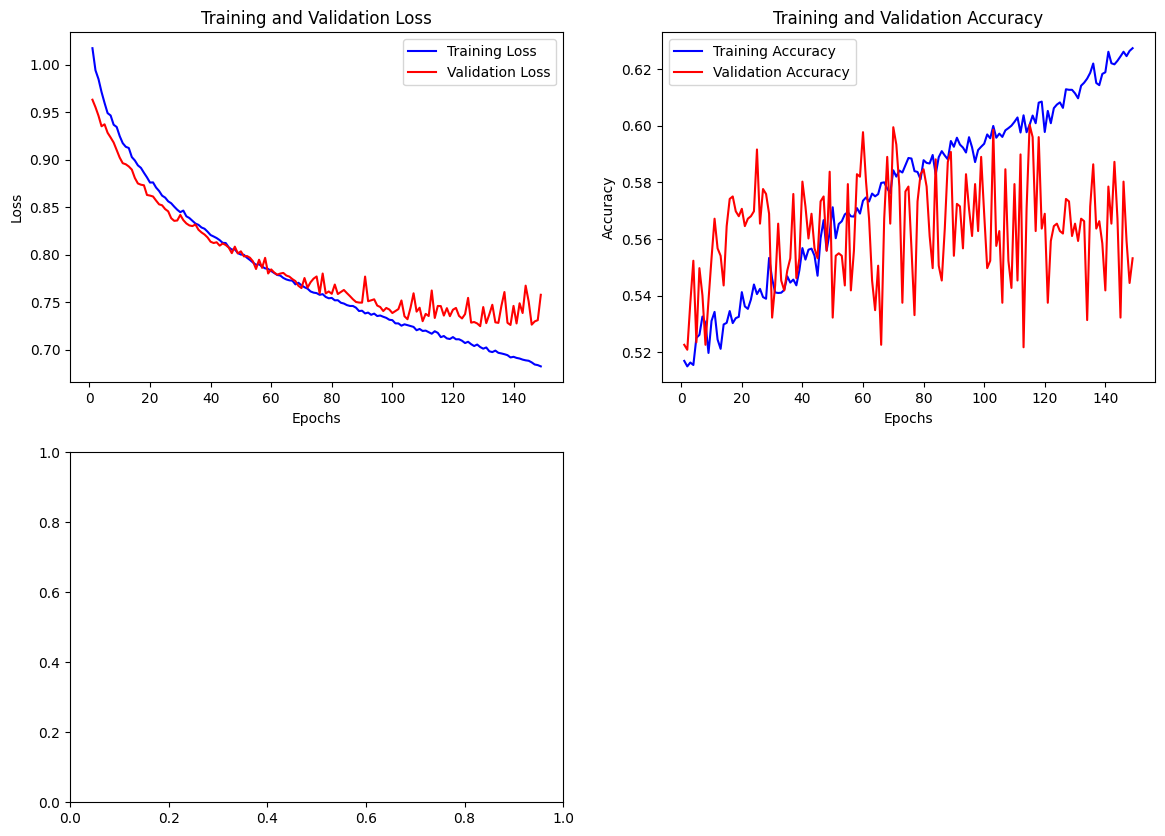

In [26]:
import matplotlib.pyplot as plt

# Extraer los datos del historial de entrenamiento
loss = history.history['loss']
val_loss = history.history['val_loss']
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

epochs = range(1, len(loss) + 1)  # Crear un rango de valores para los ejes X (número de épocas)

# Crear el gráfico para 'Loss'
plt.figure(figsize=(14, 10))

plt.subplot(2, 2, 1)  # Subplot 1 (1 fila, 2 columnas, primer gráfico)
plt.plot(epochs, loss, 'b-', label='Training Loss')  # Azul para entrenamiento
plt.plot(epochs, val_loss, 'r-', label='Validation Loss')  # Rojo para validación
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Crear el gráfico para 'Accuracy'
plt.subplot(2, 2, 2)  # Subplot 2 (1 fila, 2 columnas, segundo gráfico)
plt.plot(epochs, accuracy, 'b-', label='Training Accuracy')  # Azul para entrenamiento
plt.plot(epochs, val_accuracy, 'r-', label='Validation Accuracy')  # Rojo para validación
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.legend()

# Gráfico de Learning Rate
plt.subplot(2, 2, 3)
plt.plot(epochs, history.history['learning_rate'], 'g-', label='Learning Rate')
plt.title('Learning Rate Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Learning Rate')
plt.legend()

plt.show()




Mostramos la matriz de confusión

36/36 [==============================] - 2s 14ms/step


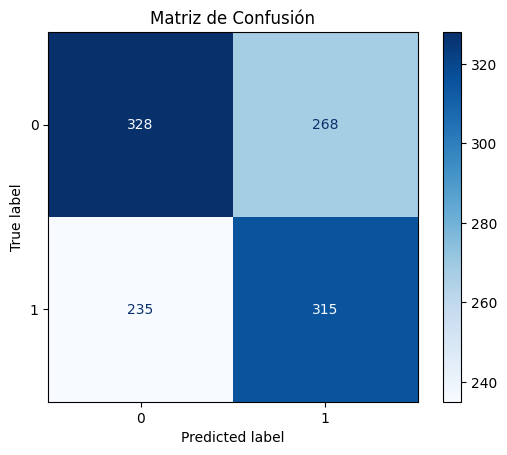

              precision    recall  f1-score   support

           0       0.58      0.55      0.57       596
           1       0.54      0.57      0.56       550

    accuracy                           0.56      1146
   macro avg       0.56      0.56      0.56      1146
weighted avg       0.56      0.56      0.56      1146



In [27]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report



# Ahora, usa las secuencias codificadas para las predicciones
y_pred = (model.predict(test_input) > 0.5).astype("int32")  # Umbral de 0.5 para clasificación

# Obtener la matriz de confusión
cm = confusion_matrix(test_labels, y_pred)

# Mostrar la matriz de confusión
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Matriz de Confusión')
plt.show()

# Reporte de clasificación
report = classification_report(test_labels, y_pred, zero_division=0)
print(report)


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step


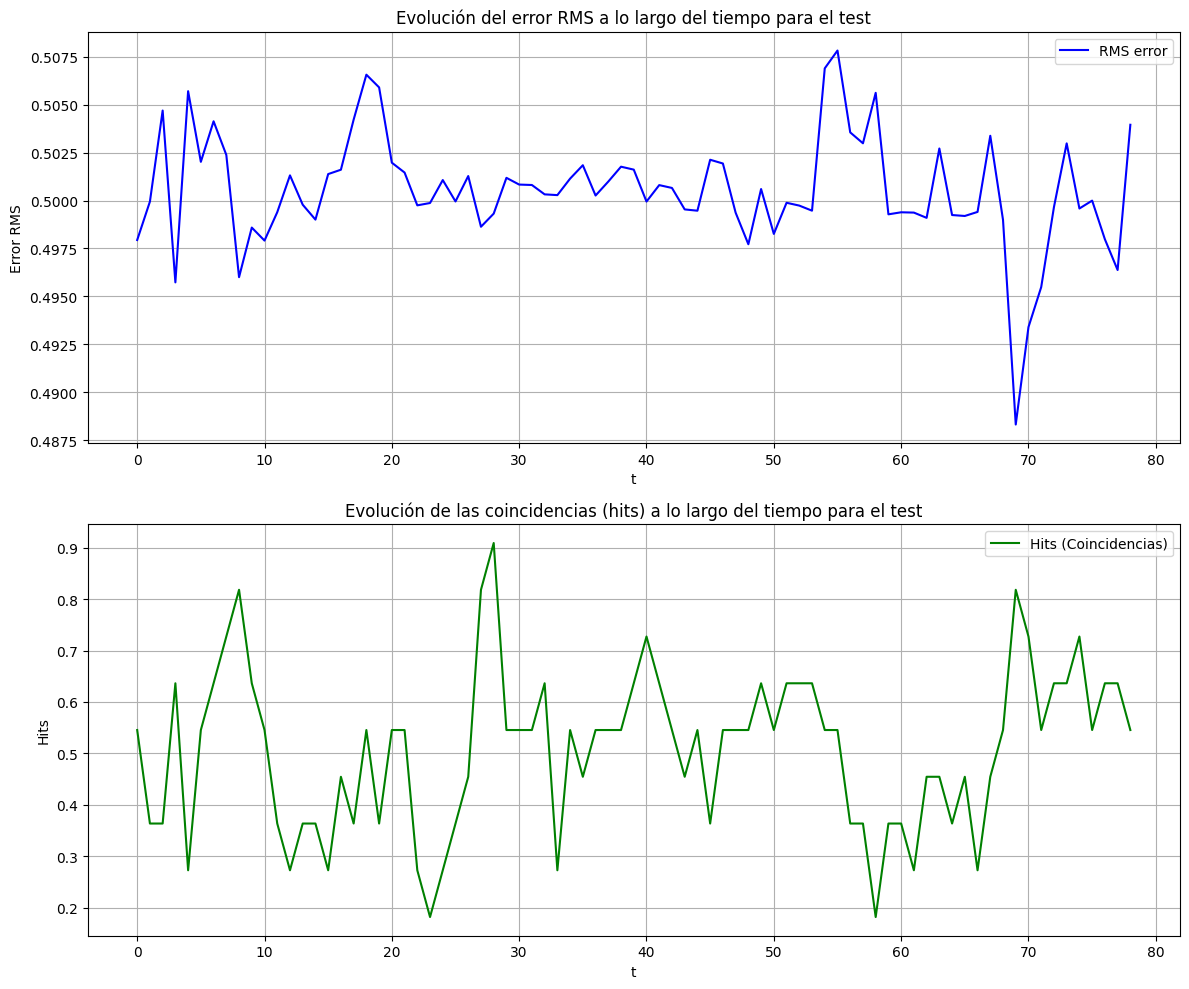

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as p

# Generamos predicciones para el conjunto de test
predictions = model.predict(test_input)

# Convertimos las probabilidades a etiquetas binarias (0 o 1)
predicted_labels = (predictions > 0.5).astype(int)  # Convierte las probabilidades a etiquetas binarias

# Separamos el conjunto de test entre las empresas que hay
value_test_labels = []
value_test_predictions = []
value_predicted_labels = []
i = 0
for l in test_lengths:
    value_test_labels.append(train_labels[i:(i+l)])
    value_test_predictions.append(predictions[i:(i+l)])
    value_predicted_labels.append(predicted_labels[i:(i+l)])
    i += l



# Calculo la longitud mínima de todos los conjuntos de test
lengths = [len(e) for e in value_test_labels]
min_length = min(lengths)

errors = []
hits = []

for t in range(min_length):
    labels = []
    predictions = []
    p_labels = []

    # Extrae los elementos de cada lista en el índice t
    for e in range(len(value_test_labels)):
        labels.append(value_test_labels[e][t])
        predictions.append(value_test_predictions[e][t])
        p_labels.append(value_predicted_labels[e][t])

    # Calcula el RMS para este instante
    errors.append(np.sqrt(np.mean((np.array(labels) - np.array(predictions)) ** 2)))

    # Calcula los hits como el porcentaje de coincidencias entre labels y p_labels
    hits.append(np.sum(np.array(labels) == np.array(p_labels).flatten()) / len(labels))
    #print(len(labels))
    #print(np.array(labels) )
    #print(np.array(p_labels).flatten())
    #print(np.array(labels) == np.array(p_labels).flatten())
    #print(np.sum(np.array(labels) == np.array(p_labels).flatten()))
    #print(hits)

plt.figure(figsize=(12, 10))

# Primer gráfico: Evolución del error RMS
plt.subplot(2, 1, 1)
plt.plot(errors, label='RMS error', color='blue')
plt.xlabel('t')
plt.ylabel('Error RMS')
plt.title('Evolución del error RMS a lo largo del tiempo para el test')
plt.legend()
plt.grid(True)

# Segundo gráfico: Representación del vector hits
plt.subplot(2, 1, 2)
plt.plot(hits, label='Hits (Coincidencias)', color='green')
plt.xlabel('t')
plt.ylabel('Hits')
plt.title('Evolución de las coincidencias (hits) a lo largo del tiempo para el test')
plt.legend()
plt.grid(True)

plt.tight_layout()  # Ajusta el espacio entre los gráficos
plt.show()


In [ ]:
test_lengths

[217, 213, 213, 174, 190, 98]

In [ ]:
model.save("model_15.keras")

In [ ]:
!zip -r model6.zip model6/

In [ ]:
from google.colab import files
files.download('model_15.keras')

In [ ]:
from tensorflow.keras.models import load_model

# Asegúrate de usar el nombre correcto del archivo que subiste
model = load_model('model_15.keras')

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 18 variables whereas the saved optimizer has 34 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [ ]:

!pip install -U numpy pandas



   ---------------------------------------- 0.0/12.9 MB ? eta -:--:--
   ------------- -------------------------- 4.5/12.9 MB 26.7 MB/s eta 0:00:01
   ------------------------------ --------- 9.7/12.9 MB 25.2 MB/s eta 0:00:01
   ---------------------------------------  12.8/12.9 MB 23.7 MB/s eta 0:00:01
   ---------------------------------------- 12.9/12.9 MB 20.7 MB/s eta 0:00:00
   ---------------------------------------- 0.0/11.6 MB ? eta -:--:--
   ------------ --------------------------- 3.7/11.6 MB 19.8 MB/s eta 0:00:01
   ------------------------------ --------- 8.9/11.6 MB 22.1 MB/s eta 0:00:01
   ---------------------------------------- 11.6/11.6 MB 20.2 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: pandas
    Found existing installation: pandas 2.0.3
    Uninstalling pandas-2.0.3:
      Successfully uninstalled pandas-2.0.3


  You can safely remove it manually.
  You can safely remove it manually.
  You can safely remove it manually.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gensim 4.3.0 requires FuzzyTM>=0.4.0, which is not installed.
tables 3.8.0 requires blosc2~=2.0.0, which is not installed.
tables 3.8.0 requires cython>=0.29.21, which is not installed.
numba 0.57.1 requires numpy<1.25,>=1.21, but you have numpy 2.1.3 which is incompatible.
scipy 1.11.1 requires numpy<1.28.0,>=1.21.6, but you have numpy 2.1.3 which is incompatible.
tensorflow-intel 2.18.0 requires numpy<2.1.0,>=1.26.0, but you have numpy 2.1.3 which is incompatible.
